In [2]:
#ASE model

In [3]:
#only works with BULK reference folders index 008 and up

In [4]:
#imports:

from ase import Atom
from ase import Atoms
from ase.io import read, write
from ase.build import surface, cut
from ase.optimize import BFGS
from ase.constraints import UnitCellFilter
from ase.visualize import view
from ase.constraints import FixedLine

import pyace

from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

import csv
import os
import shutil
import subprocess
import re
import sys
import copy
from scipy.interpolate import griddata


In [5]:
#Safty copy of the ML_Potential: /nfshome/karanikv/TU-Darmstadt-Work/Training_Potentials/2025_03_03_ReFitting_8_embending_functions_gpunode2/potential_iteration_1559_new_kappa_0p05.yaml in nfshome/okresa/
path_to_pot = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential"
potential_name = "potential_iteration_1559_new_kappa_0p05.yaml"

print(f'Path_to_potential: {path_to_pot}/{potential_name}')
pot = pyace.PyACECalculator(f'{path_to_pot}/{potential_name}')


Path_to_potential: /nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ML_Potential/potential_iteration_1559_new_kappa_0p05.yaml


In [6]:
#define functions:
def gb_energy(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    Energy_uncorrect = atoms.get_potential_energy()
    e = Corrected_Energy(Energy_uncorrect,atoms)
    return (e - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


def gb_energy_averaged(atoms, eref_Cu, eref_Ag, xAg=0):
    a, b = atoms.cell[0], atoms.cell[1]
    A = np.linalg.norm(np.cross(a,b))
    #set e_avr variable after avaraging script
    return (e_avr - len(atoms) *((1 - xAg) * eref_Cu + xAg * eref_Ag)) / (2*A)


#Energy was omitted to fit a graph and must be recorrected
def Corrected_Energy(Energy_uncorrect,atoms):
    Number_Atoms = list(atoms.symbols)
    Ag_number = Number_Atoms.count('Ag')
    Cu_number = Number_Atoms.count('Cu')
    Ga_number = Number_Atoms.count('Ga')
    Se_number = Number_Atoms.count('Se')
    
    E_Ag = -0.07060507
    E_Cu = -0.06457733
    E_Ga = -0.07974831
    E_Se = -0.16179301
    return Energy_uncorrect + Ag_number*E_Ag + Cu_number*E_Cu + Ga_number*E_Ga + Se_number*E_Se


def optimize(atoms, fmax=0.1, write=False, fname=None):
    # Constrain each atom individually along the z-direction
    indices1 = [atom.index for atom in atoms]
    #c = FixedLine(indices=indices, direction=[0, 0, 1])
    indices = list(range(len(atoms)))  # Ensure indices is a list of atom indices
    CC = []
    for index in indices:
        CC.append(FixedLine(index, [0, 0, 1]))
    atoms.set_constraint(CC)

    # Initialize and run the BFGS optimizer
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)

    # Optionally write the optimized structure to a file
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


def optimize1(atoms, fmax=0.001, mask=(1, 1, 1, 0, 0, 0), write=False, fname=None):
    opt = BFGS(atoms)
    opt.run(fmax=fmax,steps=250)
    ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
    #ucf = UnitCellFilter(atoms,constant_volume=False, mask=mask)
    opt = BFGS(ucf)
    opt.run(fmax=fmax,steps=250)
    if write:
        if fname:
            atoms.write("{}".format(fname), vasp5=True, direct=True, sort=True)
        else:
            atoms.write("opt.POSCAR", vasp5=True, direct=True, sort=True)

    return None


In [7]:
# 1. Find the center of the atoms object
def find_center_of_atoms(atoms):
    # The center is the mean of the positions
    center = np.mean(atoms.positions, axis=0)
    print(f"Center of the atoms: {center}")
    return center

# 2. Find the [Cu] atom closest to the center
def find_closest_atom_to_center(atoms, center, atom_type):
    """
    Finds the atom of type `atom_type` closest to the center of the atoms object.

    Parameters:
    - atoms: The ASE Atoms object.
    - center: The center coordinates of the atoms object.
    - atom_type: The type of atom to search for (e.g., 'Cu').

    Prints the index and coordinates of the closest atom of the specified type to the center.
    """
    # Extract the positions and symbols of the atoms
    positions = atoms.positions
    symbols = atoms.symbols

    # Find the indices of atoms that match the specified atom_type
    atom_indices = [i for i, symbol in enumerate(symbols) if symbol == atom_type]

    # If no atoms of the specified type are found, print a message and return
    if not atom_indices:
        print(f"No atoms of type {atom_type} found.")
        return

    # Calculate distances from the center to each atom of the specified type
    distances = [np.linalg.norm(pos - center) for i, pos in enumerate(positions) if i in atom_indices]

    # Find the index of the closest atom
    closest_atom_index = atom_indices[np.argmin(distances)]
    closest_atom_position = atoms.positions[closest_atom_index]

    print(f"Closest {atom_type} atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")
    return closest_atom_index, closest_atom_position


# 3. Swap the [Cu] atom closest to the center with Bi
def swap_atoms(atoms, atoms_to_swap, visually_destinct_element = "Bi"):
    """
    Swaps the selected atoms with new atoms of the visually distinct element.
    
    Parameters:
    - atoms: The list of atoms.
    - atoms_to_swap: List of atom indices to be swapped.
    - visually_destinct_element: The element to swap atoms with.
    
    Returns:
    - atoms: The modified atoms with the swapped atoms.
    """
    if isinstance(atoms_to_swap, int):
        print(f"The variable is an integer: {atoms_to_swap}")
        atoms[atoms_to_swap].symbol = visually_destinct_element
    elif isinstance(atoms_to_swap, list):
        print(f"The variable is a list: {atoms_to_swap}")
        for idx in sorted(atoms_to_swap, reverse=True):  # Iterate in reverse order to avoid index shifting
            # Replace the atom with a new one of the selected element (visually_distinct_element)
            print(f"Swapping atom at index {idx}: {atoms[idx]} with {visually_destinct_element}")
            atoms[idx].symbol = visually_destinct_element
    else:
        print("The variable is neither an integer nor a list.")

    return atoms

# Extra. Ask for a visulaisation of the GB
def ask_user_for_visuals(atoms, ask_to_check_visuals = "skip"):
    if ask_to_check_visuals != "skip":
        ask_to_check_visuals = input("Check with visualisation? y/N: ").strip().lower()
    if ask_to_check_visuals == 'y':
        #if y --> If possible manually fix it in ASE window 
        print("Script will continue after closing the ASE gui window.\nEdits will be saved\nplease correct the deletion layer using the Ctrl+Y feature in ASE")
        atoms.edit()
    else:
        print("Skipping visualistion.")

#5 get a line of bulk_base atoms to replace:
def get_atoms_with_larger_z(atoms, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.1):
    """
    Finds the indices of all atoms of type `bulk_base` (e.g., 'Cu') that have a larger z-coordinate
    than the atom at `closest_atom_position` and are within `y_tolerance` in the y-coordinate.
    
    Parameters:
    - atoms: List of atom objects, each with 'element' (atom type) and 'coordinates' (x, y, z).
    - bulk_base: The atom type to search for (default is 'Cu').
    - closest_atom_position: The index of the closest atom to compare against.
    - y_tolerance: The allowed tolerance in the y-coordinate to consider the atom as within range.
    
    Returns:
    - distance_to_center_index_list: A list of indices of atoms meeting the conditions.
    """
    # define distance_to_center_index_list 
    distance_to_center_index_list = [closest_atom_index]
    # Get the coordinates of the closest atom
    #closest_atom = atoms[closest_atom_index]
    closest_atom_x = closest_atom_position[0]
    closest_atom_y = closest_atom_position[1]
    closest_atom_z = closest_atom_position[2]
    print(f"TEST 1: closest_atom_position: {closest_atom_position}")
    print(f"TEST 1: x = {closest_atom_x}, y = {closest_atom_y}, z = {closest_atom_z} ")
    # Iterate through the atoms to find matching atoms
    for idx, atom in enumerate(atoms):
        #atom(symbol='X', position=(0, 0, 0), tag=None, momentum=None, mass=None, magmom=None, charge=None, atoms=None, index=None)
        atom_x = atom.position[0]
        atom_y = atom.position[1]
        atom_z = atom.position[2]
        
         # Check if the z-coordinate of a bulk_base is larger then the center and the y-coordinate is within tolerance
        if atom.symbol == bulk_base and atom_z > closest_atom_z and abs(atom_y - closest_atom_y) <= y_tolerance:
            print(f"TEST 2: x = {atom_x}, y = {atom_y}, z = {atom_z}")
            distance_to_center_index_list.append(idx)      
    
    return distance_to_center_index_list

In [8]:
#Referece bulk energy (Eb) <--------- needs to be corrrected again

ref_Cu = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2.POSCAR")
ref_Cu.set_calculator(pot)
optimize1(ref_Cu,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/CuGaSe2_rel.POSCAR")
eref_Cu = ref_Cu.get_potential_energy() / len(ref_Cu)
#---------------------
#eref_Cu_uncorrected = ref_Cu.get_potential_energy() / len(ref_Cu)
#eref_Cu = Corrected_Energy(eref_Cu_uncorrected,ref_Cu) #E_b (reference bulk energy per Atom)
#---------------------
print(f"\nRefecrence Bulk Energy Cu: {eref_Cu}\n") #problem: at T=0K

ref_Ag = read("/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2.POSCAR")
ref_Ag.set_calculator(pot)
optimize1(ref_Ag,write=True, fname="/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/input/ASE_Scripts_input/unit_cell/AgGaSe2_rel.POSCAR")
#eref_Ag = ref_Ag.get_potential_energy() / len(ref_Ag)
#---------------------
eref_Ag_uncorrected = ref_Ag.get_potential_energy() / len(ref_Ag)
eref_Ag = Corrected_Energy(eref_Ag_uncorrected,ref_Ag)
#---------------------
print(f"\nRefecrence Bulk Energy Ag: {eref_Ag}\n")

print("Note: should be close to -3.898 in Vac ver.")
print("\n\nDONE")

      Step     Time          Energy          fmax
BFGS:    0 16:00:41      -60.539534        0.030474


/tmp/ipykernel_2198601/3902203599.py:4: DeprecationWarning: Please use atoms.calc = calc
  ref_Cu.set_calculator(pot)


BFGS:    1 16:00:41      -60.539633        0.026715
BFGS:    2 16:00:41      -60.539964        0.000007
      Step     Time          Energy          fmax
BFGS:    0 16:00:41      -60.539964        0.033752
BFGS:    1 16:00:42      -60.539988        0.033623
BFGS:    2 16:00:42      -60.543144        0.014454
BFGS:    3 16:00:42      -60.543166        0.012604
BFGS:    4 16:00:42      -60.543242        0.000416

Refecrence Bulk Energy Cu: -3.7839526323936408

      Step     Time          Energy          fmax
BFGS:    0 16:00:42      -56.023459        0.006862
BFGS:    1 16:00:42      -56.023464        0.006095
BFGS:    2 16:00:42      -56.023483        0.000000
      Step     Time          Energy          fmax
BFGS:    0 16:00:42      -56.023483        0.019965
BFGS:    1 16:00:42      -56.023492        0.019907
BFGS:    2 16:00:42      -56.024944        0.008026


/tmp/ipykernel_2198601/4070876573.py:59: FutureWarning: Import UnitCellFilter from ase.filters
  ucf = UnitCellFilter(atoms,constant_volume=True, mask=mask)
/tmp/ipykernel_2198601/3902203599.py:14: DeprecationWarning: Please use atoms.calc = calc
  ref_Ag.set_calculator(pot)


BFGS:    3 16:00:42      -56.024951        0.007037
BFGS:    4 16:00:42      -56.024974        0.001440
BFGS:    5 16:00:42      -56.024977        0.000255

Refecrence Bulk Energy Ag: -5.397318665252235

Note: should be close to -3.898 in Vac ver.


DONE


In [9]:
#common target for graphs in docs:
common_graph_folder = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection"
common_graph_path = Path(common_graph_folder) 

print(common_graph_path)

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/docs/exemple_graph_collection


In [9]:
#.glob(): This method is used to search for files or directories matching a specific pattern within base_path.
#         * is a wildcard matching any characters (zero or more).

In [11]:


#opt 1 read



Folder name for 013 is: LAMMPS_Submision_013_02-05-2025_17-11-28
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data


/nfshome/okresa/anaconda3/envs/ASE_pyace_aimsgb/lib/python3.9/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
/tmp/ipykernel_12898/3984390577.py:96: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1483.1560129263605 eV
GB Formation Energy:
-1.5357463089146168 J/m²
The Energy (per atom) is: -3.862385450329064 in eV per atom
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_24z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
-2981.1117126055888 eV
GB Formation Energy:
-3.826138072362096 J/m²
The Energy (per atom) is: -3.881655875788527 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_013_02-05-2025_17-11-28/8_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_36z-layers.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
-4479.0746312168185 eV
GB Formation Energy:
-6.1168

NameError: name 'submission_graph_path' is not defined

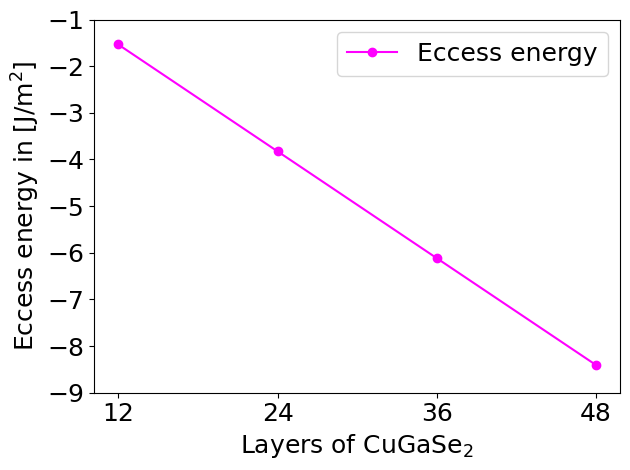

In [12]:
#MARKED!!!
#Read output optimize1 print convergence | usefull for Figure 1 --> 013 for excess

#Up to DATE 03_05_2025 custom input version (does not reference ral bulk!!!)

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy
#note LAMMPS 8 rep takes ~12 min + extra time to finish on the gpu node

# Ask the user for the LAMMPS index
LAMMPS_index = []
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
LAMMPS_index = "013"

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []
layer = []
bulk_layer = []
layers = []
bulk_layers = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Find the folder name matching the pattern for LAMMPS_Submision
folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Loop through the files matching the pattern
for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue  # Skip this file and go to the next one
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based files: No repetition found")
            #continue  # Skip if no repetition is found
            
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
        
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        Total_Energy.append(e_pot)

        #calc formation_energy
        Formation_Energy.append(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218)
        print("GB Formation Energy:")
        print(gb_energy(atoms1, eref_Cu, eref_Ag, xAg=0) * 16.0218, "J/m²")  # mit 16.0218 umrechnungsfaktor für eV/Å² zu J/m²

        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        if rep:
            print(f"{rep}reps_done\n")
            repeat.append(rep)
        if layer:
            print(f"{layer}layers_done\n")
            layers.append(layer)



#plot formation energy over repetitions of the supercell

print("Formation_energy_v2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel('Eccess energy(J/m$^2$)',fontsize = 18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    #plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Eccess energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel('Eccess energy in [J/m$^2$]',fontsize = 18)
    plt.yticks(fontsize=18)
    plt.yticks(np.arange(-9, 0, 1))
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_ref.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_ref.png", bbox_inches='tight') 
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

### test

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  016


Folder name for 016 is: LAMMPS_Submision_016_14-05-2025_11-41-53
LAMMPS_Submission:
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.mini.data
Skipping rep based file: No repetition found
Confirm file: optimize1.data
Bulk potential Energy:
-1387.3795258754167 eV
The bulk Energy (per atom) is: -3.6898391645622786 in eV per atom
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
896.0212530933018 eV
The Ener

/tmp/ipykernel_5529/3154431952.py:137: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)
/tmp/ipykernel_5529/3154431952.py:184: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Bulk potential Energy:
-2900.377548307949 eV
The bulk Energy (per atom) is: -3.816286247773617 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_GB_S9_24z-layers_20A-VACUUMS.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize1.data
Supercell potential Energy:
-606.3779687871422 eV
The Energy (per atom) is: -0.7978657484041345 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.mini.data
Skipping rep based file: No repetition found
Confirm file: optimize1.data
Bulk potential Energy:
-4409.058528309815 eV
The bulk Energy (per atom) is: -3.8540721401309574 in eV per atom
36layers_done

/nfshome/okresa/Bachelor_The

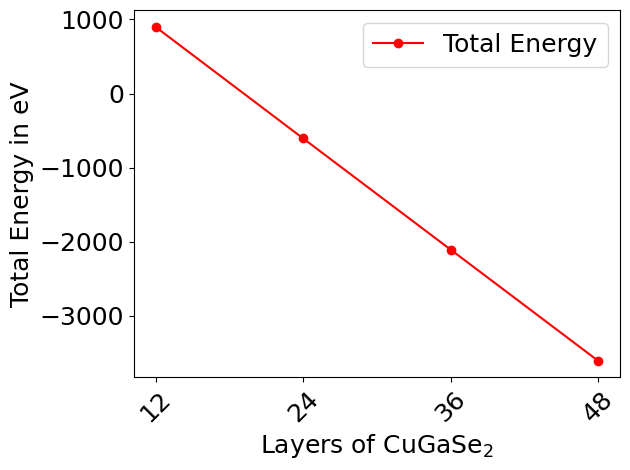


The Total Energies are (red): [896.0212530933018, -606.3779687871422, -2105.4081124789445, -3604.1627604272053] (in eV)
The Bulk energies E_b are (orange): [-1387.3795258754167, -2900.377548307949, -4409.058528309815, -5914.732500155417] (in eV)


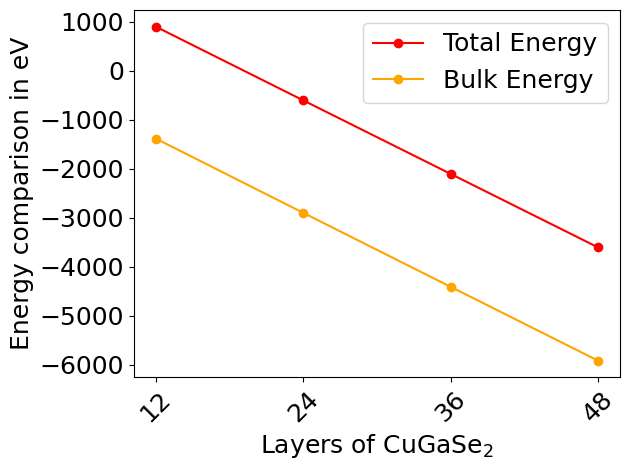


Testing:
The Total energies per atom are: [2.3830352475885683, -0.7978657484041345, -1.840391706712364, -2.3587452620596894]
The Bulk energies per Atom are: [-3.6898391645622786, -3.816286247773617, -3.8540721401309574, -3.870898233086006] (in eV per Atom)
The Energy difference per Atom is: [6.072874412150847, 3.0184204993694825, 2.0136804334185934, 1.5121529710263166] (in eV per Atom)
The Energy difference is: [2283.4007789687184, 2293.999579520807, 2303.6504158308708, 2310.569739728212] (in eV)
The Energy difference per Area of the GB is: [14.531783357121792, 14.599235148715668, 14.66065400420727, 14.704689250573145] (in eV/Å²)
The Energy difference per Area of the GB is: [232.82532659113392, 233.90602570569266, 234.89006632460803, 235.5955902348328] (in J/m²)
The Energy difference is: [2283.4007789687184, 2293.999579520807, 2303.6504158308708, 2310.569739728212] (in eV)


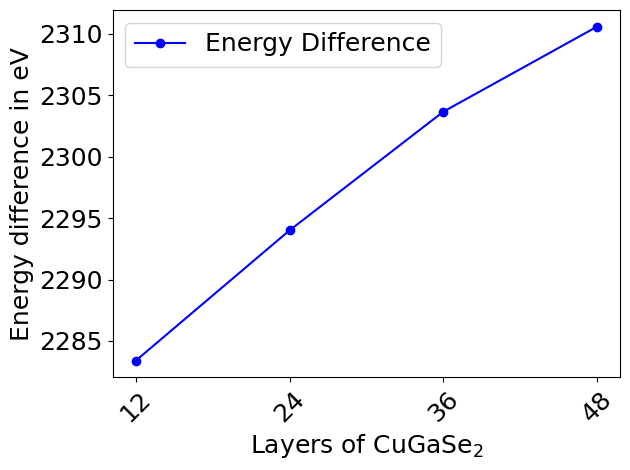



The Total energies per atom are (red): [2.3830352475885683, -0.7978657484041345, -1.840391706712364, -2.3587452620596894] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.6898391645622786, -3.816286247773617, -3.8540721401309574, -3.870898233086006] (in eV per Atom)


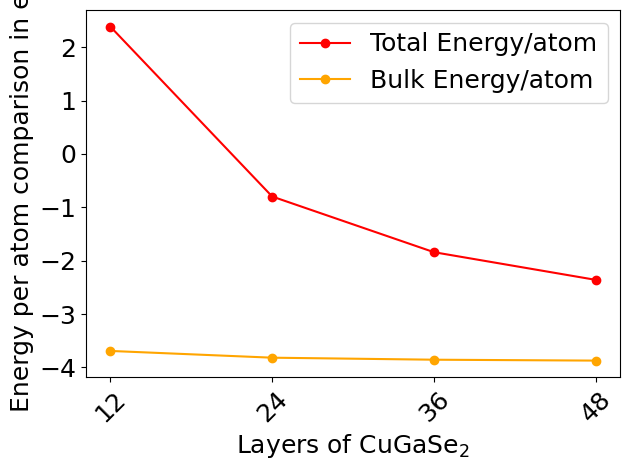

The Energy difference per Atom is: [6.072874412150847, 3.0184204993694825, 2.0136804334185934, 1.5121529710263166] (in eV)


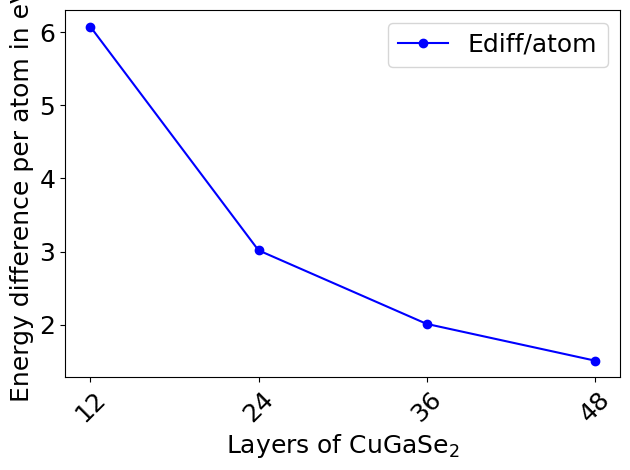



The formation energies are: [232.82532659113392, 233.90602570569266, 234.89006632460803, 235.5955902348328]
Formation_energy_v1


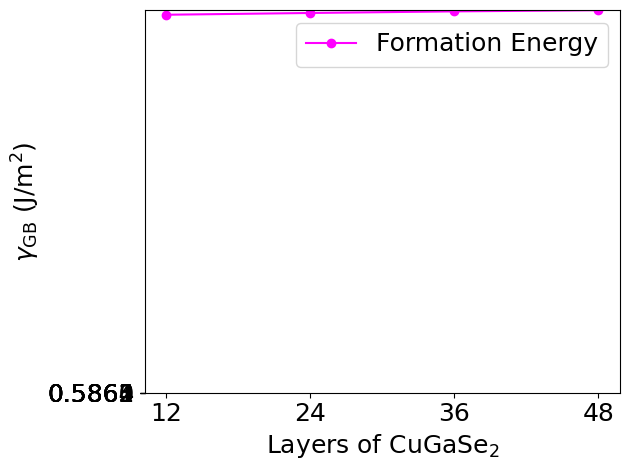

Formation_energy_v1.2


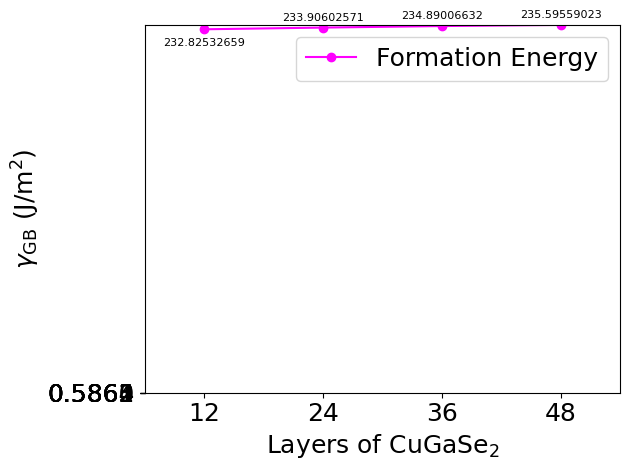

Formation_energy_v2


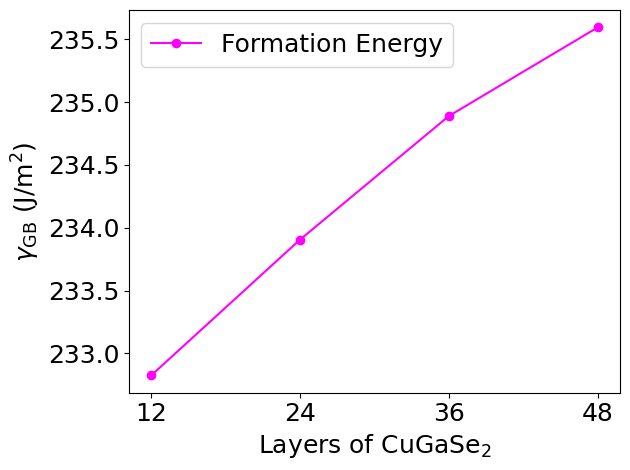

Formation_energy_v2.2


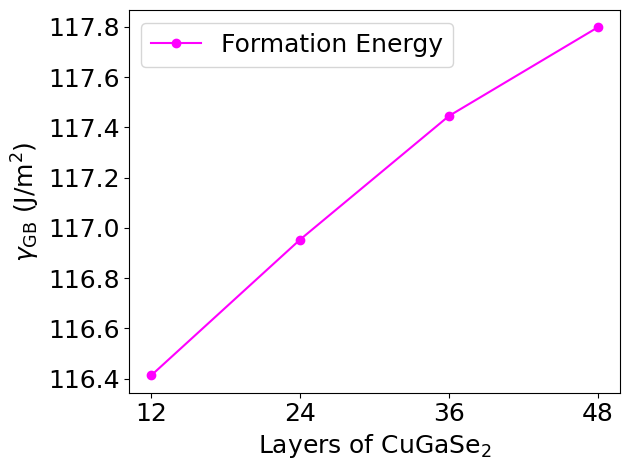

Formation_energy_v3


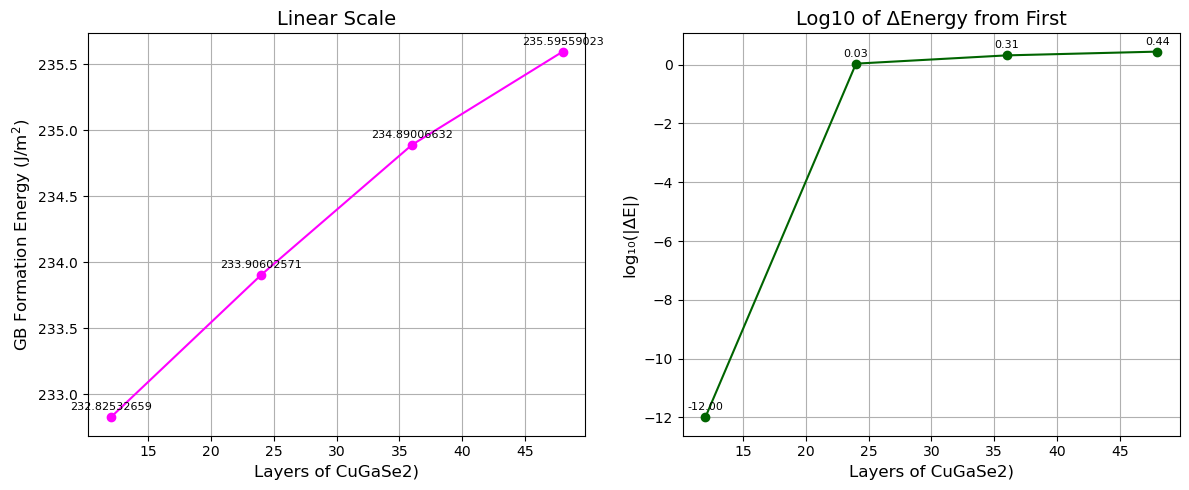


Timestamp:
19-05-2025 17:40


In [35]:
### MARKED!!!

#Read output optimize1 print convergence | usefull for Figure 1 and 3 --> 013 for excess | 010 for formation energies
#Up to DATE 15_04_2025 custom input version

#Read output optimize1 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#needs short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []
layer = []
bulk_layer = []
layers = []
bulk_layers = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt1_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions (now sorted):

# Step 2.1: Get and sort files by extracted repetition or layer count
file_list = list(submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data")) #<-----------------------------
#file_list = list(submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize0.data"))

def extract_sort_key(f):
    # Get the parent directory for naming
    data_folder = f.parent.parent
    # Try to extract rep or layer value
    match_rep = re.search(r'(\d+)rep.*\.data$', data_folder.name)
    match_layer = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
    
    if match_rep:
        return int(match_rep.group(1))
    elif match_layer:
        return int(match_layer.group(1))
    else:
        return float('inf')  # Put unmatched files at the end

# Sort the file list by repetition or layer
file_list.sort(key=extract_sort_key)

""" 
Quick note:
to force a specific sort (e.g., prioritize layers over reps), you can modify extract_sort_key() accordingly — e.g., return a tuple like:

return (0, int(match_layer.group(1))) if match_layer else (1, int(match_rep.group(1))) if match_rep else (2, float('inf'))

That would sort layers first, then reps, then unmatched.
"""

# Step 2.2: Loop through the files and calculate the energies based on Bulk and GB versions 
#for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
for f in file_list:
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based file: No repetition found")
            #continue  # Skip if no repetition is found
        
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            bulk_layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            bulk_layer = int(bulk_layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
            
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        Bulk_Energy.append(e_bulk)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        
        if bulk_rep:
            print(f"{bulk_rep}reps_done\n")
            bulk_repeat.append(bulk_rep)
        if bulk_layer:
            print(f"{bulk_layer}layers_done\n")
            bulk_layers.append(bulk_layer)   
        
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based files: No repetition found")
            #continue  # Skip if no repetition is found
            
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
        
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        Total_Energy.append(e_pot)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        if rep:
            print(f"{rep}reps_done\n")
            repeat.append(rep)
        if layer:
            print(f"{layer}layers_done\n")
            layers.append(layer) 

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
print(f"Total Energy list: {Total_Energy}")
print(f"Bulk Energy list: {Bulk_Energy}")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"For the layer count: {layers}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='Total Energy',color='red')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),np.asarray(Total_Energy),marker='o',label='Total Energy',color='red')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy in eV',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Total_Energy), marker='o', label='Total Energy', color='red')
    plt.plot(np.asarray(repeat), np.asarray(Bulk_Energy), marker='o', label='Bulk Energy', color='orange')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    # plt.xlabel('Repetitions', fontsize=18)  # optional alternate label
    plt.yticks(fontsize=18)
    plt.ylabel('Energy comparison in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Total_Energy), marker='o', label='Total Energy', color='red')
    plt.plot(np.asarray(layers), np.asarray(Bulk_Energy), marker='o', label='Bulk Energy', color='orange')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or just plt.xticks(layers)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    # plt.xlabel('Layers of CuGaSe2', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy comparison in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
    #Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Ediff), marker='o', label='Energy Difference', color='blue')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy difference in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Ediff), marker='o', label='Energy Difference', color='blue')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy difference in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Total_Energy_per_atom), marker='o', label='Total Energy/atom', color='red')
    plt.plot(np.asarray(repeat), np.asarray(Bulk_Energy_per_atom), marker='o', label='Bulk Energy/atom', color='orange')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy per atom comparison in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Total_Energy_per_atom), marker='o', label='Total Energy/atom', color='red')
    plt.plot(np.asarray(layers), np.asarray(Bulk_Energy_per_atom), marker='o', label='Bulk Energy/atom', color='orange')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy per atom comparison in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

"""
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions in $\AA$',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()
"""

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Ediff_per_atom), marker='o', label='Ediff/atom', color='blue')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel('Energy difference per atom in eV', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Ediff_per_atom), marker='o', label='Ediff/atom', color='blue')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel('Energy difference per atom in eV', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()


# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


# Step 11: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

"""
plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat), max(repeat), 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()
"""

print("Formation_energy_v1")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat), max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #plt.yticks(np.arange(0.586, 0.587, 0.0001))  # hardcoded narrow range
    plt.yticks(fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    #plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Eccess energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    #plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel('GB Formation energy (J/m$^2$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.ylabel('Eccess energy in [J/m$^2$]',fontsize = 18)
    #scale for convergence 010: 
    #old plt.yticks(np.arange(0.586, 0.587, 0.0001))
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #scale for excess 013: 
    #plt.yticks(np.arange(1.5088, 1.5100, 0.0002))
    plt.yticks(fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

"""
plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()
"""

print("Formation_energy_v1.2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    padding = 1
    plt.xlim(min(layers) - padding, max(layers) + padding)
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.yticks(np.arange(0.586, 0.587, 0.0001))  # hardcoded narrow range
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    plt.yticks(fontsize=18)
    for x, y in zip(repeat, Formation_Energy):
        plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    #plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Eccess energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    padding = 6
    plt.xlim(min(layers) - padding, max(layers) + padding)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel(r'$\gamma_{\mathrm{GB}}$ in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.ylabel('Eccess energy in [J/m$^2$]',fontsize = 18)
    #scale for convergence 010: 
    #old plt.yticks(np.arange(0.586, 0.587, 0.0001))
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #scale for excess 013: 
    #plt.yticks(np.arange(1.5088, 1.5100, 0.0002))
    plt.yticks(fontsize=18)
    for x, y in zip(layers, Formation_Energy):
        if x == layers[0]: 
            plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, -12), ha='center', fontsize=8)
        else:
            plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    plt.tight_layout()

"""
# Annotations
for x, y in zip(xdata, ydata):
    plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 12), ha='center', fontsize=8)

# Symmetric padding on x-axis
padding = 1
plt.xlim(min(xdata) - padding, max(xdata) + padding)
"""

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v2.2")

Formation_Energy_half = []
for i in range(4):
    Formation_Energy_half.append(Formation_Energy[i] * (1/2))

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    #plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v3")

def plot_formation_comparison(x_values, Formation_Energy, x_label_title="Repetitions ($\AA$)"):
    """
    Plots GB Formation Energy in linear scale and log10 of the difference
    relative to the first energy value for sensitivity analysis.
    
    Parameters:
    - x_values: List[int or float] - x-axis values (e.g., repetitions or layers)
    - formation_energy: List[float] - GB formation energies
    - x_label_title: str - Label for the x-axis (default is for repetitions)
    """

    # Compute log10 of delta energies (from first value)
    ref_energy = Formation_Energy[0]
    log_deltas = [np.log10(abs(e - ref_energy) + 1e-12) for e in Formation_Energy]  # Add small value to avoid log(0)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    # --- Plot 1: Linear Scale ---
    ax1.plot(x_values, Formation_Energy, marker='o', color='magenta', label='Formation Energy')
    ax1.set_title("Linear Scale", fontsize=14)
    ax1.set_xlabel(x_label_title, fontsize=12)
    ax1.set_ylabel("GB Formation Energy (J/m$^2$)", fontsize=12)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.grid(True)
    for x, y in zip(x_values, Formation_Energy):
        ax1.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    """
    #save the plot
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """

    # --- Plot 2: Log10 of Differences ---
    ax2.plot(x_values, log_deltas, marker='o', color='darkgreen', label='log₁₀(|ΔE|)')
    ax2.set_title("Log10 of ΔEnergy from First", fontsize=14)
    ax2.set_xlabel(x_label_title, fontsize=12)
    ax2.set_ylabel("log₁₀(|ΔE|)", fontsize=12)
    ax2.tick_params(axis='both', labelsize=10)
    ax2.grid(True)
    for x, y in zip(x_values, log_deltas):
        ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    #save the plot
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_delta_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_delta_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """

    #show the plots next to each other
    plt.tight_layout()
    plt.show()

if repeat:
    plot_formation_comparison(repeat, Formation_Energy, "Repetitions ($\AA$)")
else:
    plot_formation_comparison(layers, Formation_Energy, "Layers of CuGaSe2)")



# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  016


Folder name for 016 is: LAMMPS_Submision_016_14-05-2025_11-41-53
LAMMPS_Submission:
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.mini.data
Skipping rep based file: No repetition found
Confirm file: optimize0.data
Bulk potential Energy:
-1390.6180886715276 eV
The bulk Energy (per atom) is: -3.6984523634881055 in eV per atom
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_GB_S9_12z-layers_20A-VACUUMS.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize0.data


/tmp/ipykernel_5529/2389681477.py:136: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)
/tmp/ipykernel_5529/2389681477.py:183: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
894.0795620561146 eV
The Energy (per atom) is: 2.3778711756811557 in eV per atom
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS.mini.data
Skipping rep based file: No repetition found
Confirm file: optimize0.data
Bulk potential Energy:
-2905.678381718955 eV
The bulk Energy (per atom) is: -3.8232610285775723 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_GB_S9_24z-layers_20A-VACUUMS.mini.data
Skipping rep based files: No repetition found
Confirm file: optimize0.data
Supercell potential Energy:
-604.5822289842972 eV
The Energy (per atom) is: -0.7955029328740753 in eV per atom
24layers_done

/nfshome/okresa/Bachelor_Thes

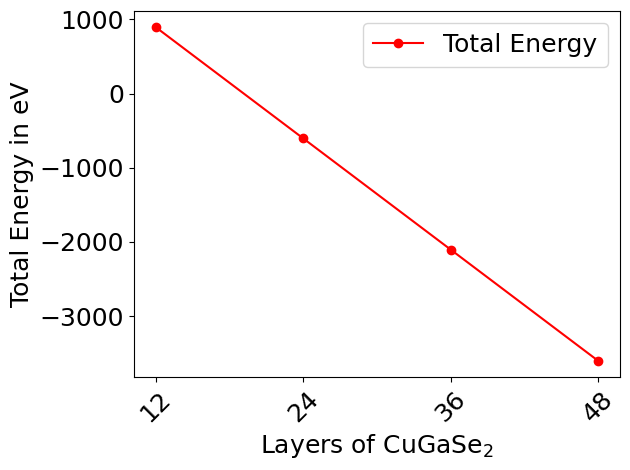


The Total Energies are (red): [894.0795620561146, -604.5822289842972, -2103.0441075106737, -3601.698418727758] (in eV)
The Bulk energies E_b are (orange): [-1390.6180886715276, -2905.678381718955, -4414.797865633827, -5920.145398586289] (in eV)


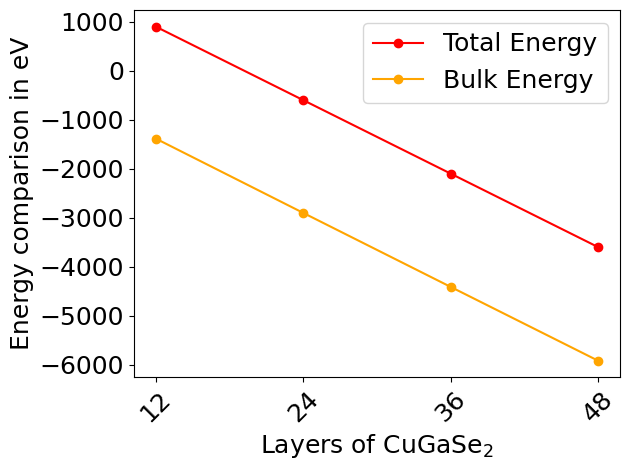


Testing:
The Total energies per atom are: [2.3778711756811557, -0.7955029328740753, -1.8383252688030365, -2.3571324729893703]
The Bulk energies per Atom are: [-3.6984523634881055, -3.8232610285775723, -3.859089043386213, -3.8744407058810792] (in eV per Atom)
The Energy difference per Atom is: [6.076323539169261, 3.027758095703497, 2.0207637745831764, 1.517308232891709] (in eV per Atom)
The Energy difference is: [2284.697650727642, 2301.0961527346576, 2311.7537581231536, 2318.446979858531] (in eV)
The Energy difference per Area of the GB is: [14.542459461711355, 14.646838503110493, 14.714675835665965, 14.757279243484051] (in eV/Å²)
The Energy difference per Area of the GB is: [232.99637700364696, 234.66871712913567, 235.75559330387293, 236.43817658325275] (in J/m²)
The Energy difference is: [2284.697650727642, 2301.0961527346576, 2311.7537581231536, 2318.446979858531] (in eV)


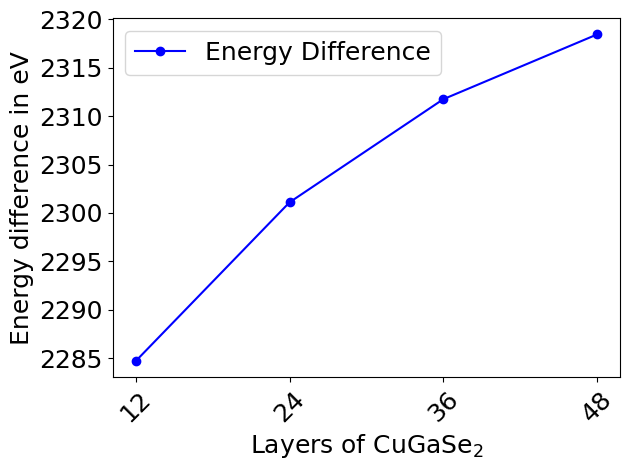



The Total energies per atom are (red): [2.3778711756811557, -0.7955029328740753, -1.8383252688030365, -2.3571324729893703] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.6984523634881055, -3.8232610285775723, -3.859089043386213, -3.8744407058810792] (in eV per Atom)


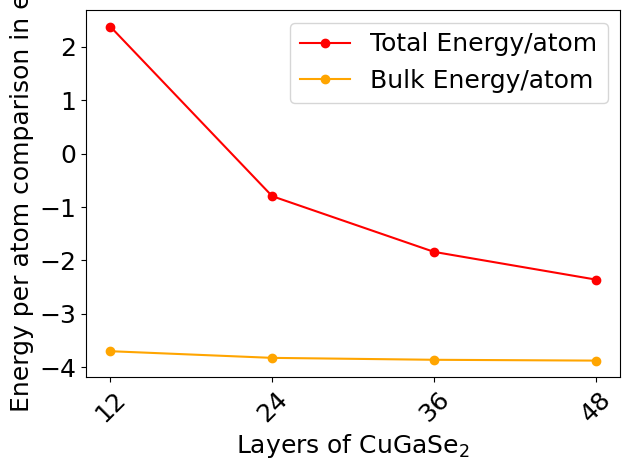

The Energy difference per Atom is: [6.076323539169261, 3.027758095703497, 2.0207637745831764, 1.517308232891709] (in eV)


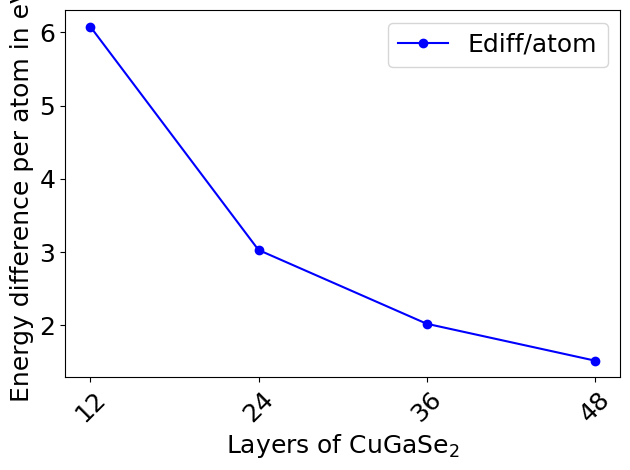



The formation energies are: [232.99637700364696, 234.66871712913567, 235.75559330387293, 236.43817658325275]
Formation_energy_v1


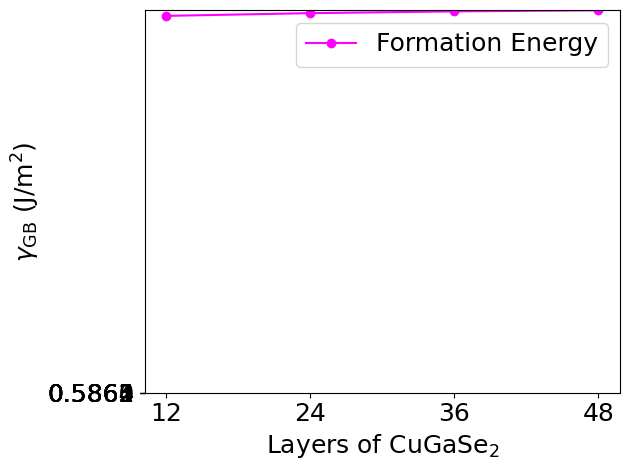

Formation_energy_v1.2


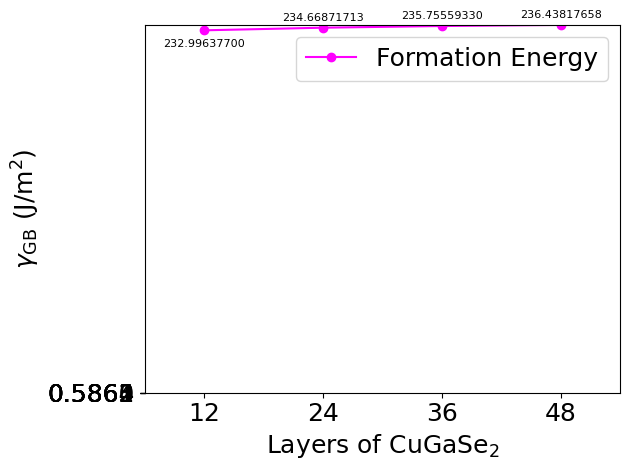

Formation_energy_v2


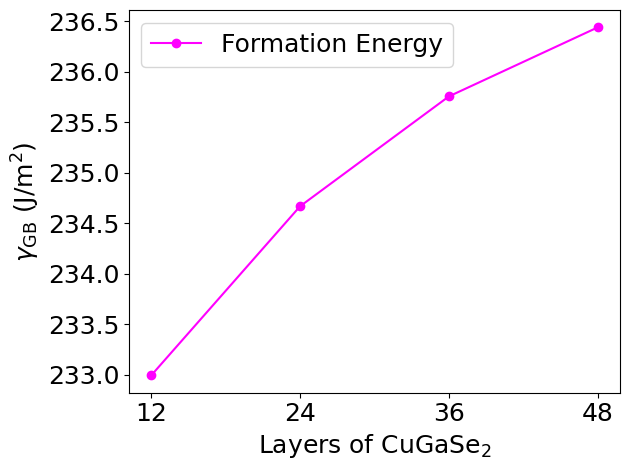

Formation_energy_v2.2


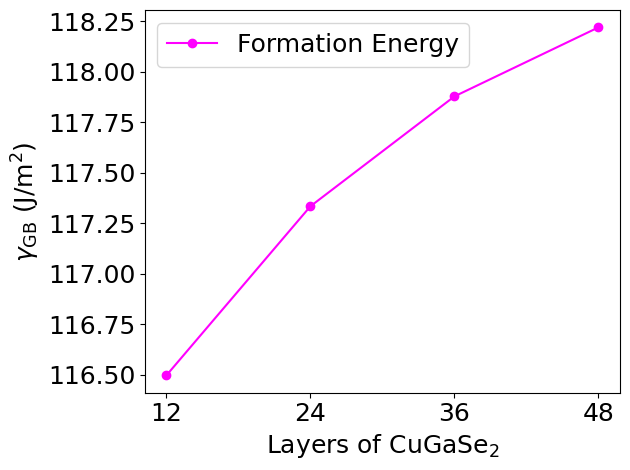

Formation_energy_v3


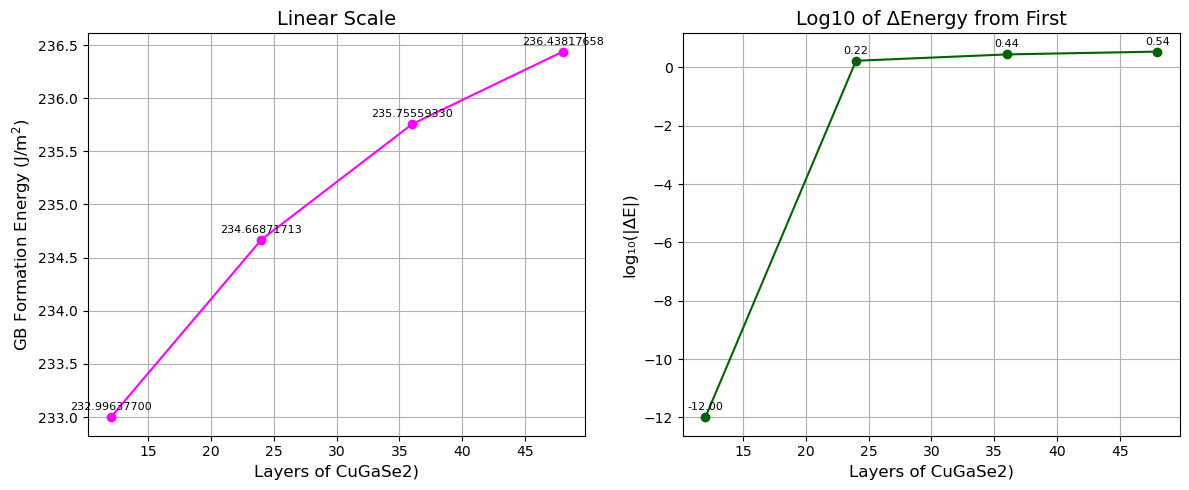


Timestamp:
19-05-2025 17:53


In [37]:
### MARKED!!!

#Read output optimize0 print convergence | usefull for Figure 1 and 3 --> 013 for excess | 010 for formation energies
#Up to DATE 15_04_2025 custom input version

#Read output optimiz0 out of _Xrep... mini.data folders and display formation energy with the E_B reference LAMMPS bulk

#needs short ver.

# Ask the user for the LAMMPS index
#LAMMPS_index = '008'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []
layer = []
bulk_layer = []
layers = []
bulk_layers = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# List all directories in the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt1_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions (now sorted):

# Step 2.1: Get and sort files by extracted repetition or layer count
file_list = list(submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize0.data"))

def extract_sort_key(f):
    # Get the parent directory for naming
    data_folder = f.parent.parent
    # Try to extract rep or layer value
    match_rep = re.search(r'(\d+)rep.*\.data$', data_folder.name)
    match_layer = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
    
    if match_rep:
        return int(match_rep.group(1))
    elif match_layer:
        return int(match_layer.group(1))
    else:
        return float('inf')  # Put unmatched files at the end

# Sort the file list by repetition or layer
file_list.sort(key=extract_sort_key)

""" 
Quick note:
to force a specific sort (e.g., prioritize layers over reps), you can modify extract_sort_key() accordingly — e.g., return a tuple like:

return (0, int(match_layer.group(1))) if match_layer else (1, int(match_rep.group(1))) if match_rep else (2, float('inf'))

That would sort layers first, then reps, then unmatched.
"""

# Step 2.2: Loop through the files and calculate the energies based on Bulk and GB versions 
#for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize0.data"):
for f in file_list:
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        print(Path(grandparent_folder))
        # If the folder does contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            bulk_rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(bulk_rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based file: No repetition found")
            #continue  # Skip if no repetition is found
        
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            bulk_layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            bulk_layer = int(bulk_layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
            
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        #n_bulk_reps.append(len(atoms1))
        e_bulk_uncorrected = atoms1.get_potential_energy()
        e_bulk = Corrected_Energy(e_bulk_uncorrected, atoms1)
        print("Bulk potential Energy:")
        print(e_bulk, "eV")
        Bulk_Energy.append(e_bulk)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_bulk
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        print(f"The bulk Energy (per atom) is: {Divided_Energy} in eV per atom")
        
        if bulk_rep:
            print(f"{bulk_rep}reps_done\n")
            bulk_repeat.append(bulk_rep)
        if bulk_layer:
            print(f"{bulk_layer}layers_done\n")
            bulk_layers.append(bulk_layer)   
        
    else:
        # If the folder does not contain "BULK", process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping rep based files: No repetition found")
            #continue  # Skip if no repetition is found
            
        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {f.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
        
        atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        atoms1.set_calculator(pot)
        n_reps.append(len(atoms1))
        e_pot_uncorrected = atoms1.get_potential_energy()
        e_pot = Corrected_Energy(e_pot_uncorrected, atoms1)
        print("Supercell potential Energy:")
        print(e_pot, "eV")
        Total_Energy.append(e_pot)
        
        #divide by atom count (needed?)
        Undivided_Energy = e_pot
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        if rep:
            print(f"{rep}reps_done\n")
            repeat.append(rep)
        if layer:
            print(f"{layer}layers_done\n")
            layers.append(layer) 

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms1.cell[0], atoms1.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")
print(f"Total Energy list: {Total_Energy}")
print(f"Bulk Energy list: {Bulk_Energy}")

# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"For the layer count: {layers}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='Total Energy',color='red')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),np.asarray(Total_Energy),marker='o',label='Total Energy',color='red')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy in eV',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Total_Energy_opt1_ver_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Total_Energy), marker='o', label='Total Energy', color='red')
    plt.plot(np.asarray(repeat), np.asarray(Bulk_Energy), marker='o', label='Bulk Energy', color='orange')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    # plt.xlabel('Repetitions', fontsize=18)  # optional alternate label
    plt.yticks(fontsize=18)
    plt.ylabel('Energy comparison in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Total_Energy), marker='o', label='Total Energy', color='red')
    plt.plot(np.asarray(layers), np.asarray(Bulk_Energy), marker='o', label='Bulk Energy', color='orange')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or just plt.xticks(layers)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    # plt.xlabel('Layers of CuGaSe2', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy comparison in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_comparison_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
    #Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Ediff), marker='o', label='Energy Difference', color='blue')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy difference in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Ediff), marker='o', label='Energy Difference', color='blue')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy difference in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Total_Energy_per_atom), marker='o', label='Total Energy/atom', color='red')
    plt.plot(np.asarray(repeat), np.asarray(Bulk_Energy_per_atom), marker='o', label='Bulk Energy/atom', color='orange')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy per atom comparison in eV', fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Total_Energy_per_atom), marker='o', label='Total Energy/atom', color='red')
    plt.plot(np.asarray(layers), np.asarray(Bulk_Energy_per_atom), marker='o', label='Bulk Energy/atom', color='orange')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylabel('Energy per atom comparison in eV', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell

"""
plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions in $\AA$',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
plt.tight_layout()
"""

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Ediff_per_atom), marker='o', label='Ediff/atom', color='blue')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel('Energy difference per atom in eV', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Ediff_per_atom), marker='o', label='Ediff/atom', color='blue')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))  # or plt.xticks(layers)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel('Energy difference per atom in eV', fontsize=18)
    plt.yticks(fontsize=18)
    plt.tight_layout()


# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()


# Step 11: plot formation energy over repetitions of the supercell: 2 variants for scale:

print("\n")
print(f"The formation energies are: {Formation_Energy}")

"""
plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat), max(repeat), 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
plt.yticks(np.arange(0.586, 0.587, 0.0001))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()
"""

print("Formation_energy_v1")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat), max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #plt.yticks(np.arange(0.586, 0.587, 0.0001))  # hardcoded narrow range
    plt.yticks(fontsize=18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    #plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Eccess energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    #plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel('GB Formation energy (J/m$^2$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.ylabel('Eccess energy in [J/m$^2$]',fontsize = 18)
    #scale for convergence 010: 
    #old plt.yticks(np.arange(0.586, 0.587, 0.0001))
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #scale for excess 013: 
    #plt.yticks(np.arange(1.5088, 1.5100, 0.0002))
    plt.yticks(fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

"""
plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18)
#plt.yticks(np.arange(0.5, 1.05, 0.05))
#plt.yticks(np.arange(min(formation_Energy)-0.005, max(formation_Energy)+0.005, 0.005))
plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
plt.tight_layout()
"""

print("Formation_energy_v1.2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    padding = 1
    plt.xlim(min(layers) - padding, max(layers) + padding)
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.yticks(np.arange(0.586, 0.587, 0.0001))  # hardcoded narrow range
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    plt.yticks(fontsize=18)
    for x, y in zip(repeat, Formation_Energy):
        plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    #plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Eccess energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    padding = 6
    plt.xlim(min(layers) - padding, max(layers) + padding)
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.ylabel(r'$\gamma_{\mathrm{GB}}$ in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    #plt.ylabel('Eccess energy in [J/m$^2$]',fontsize = 18)
    #scale for convergence 010: 
    #old plt.yticks(np.arange(0.586, 0.587, 0.0001))
    plt.yticks(np.arange(0.586, 0.5865, 0.0001))
    #scale for excess 013: 
    #plt.yticks(np.arange(1.5088, 1.5100, 0.0002))
    plt.yticks(fontsize=18)
    for x, y in zip(layers, Formation_Energy):
        if x == layers[0]: 
            plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, -12), ha='center', fontsize=8)
        else:
            plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)
    plt.tight_layout()

"""
# Annotations
for x, y in zip(xdata, ydata):
    plt.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 12), ha='center', fontsize=8)

# Symmetric padding on x-axis
padding = 1
plt.xlim(min(xdata) - padding, max(xdata) + padding)
"""

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale1_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v2")

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v2.2")

Formation_Energy_half = []
for i in range(4):
    Formation_Energy_half.append(Formation_Energy[i] * (1/2))

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    #plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_v3")

def plot_formation_comparison(x_values, Formation_Energy, x_label_title="Repetitions ($\AA$)"):
    """
    Plots GB Formation Energy in linear scale and log10 of the difference
    relative to the first energy value for sensitivity analysis.
    
    Parameters:
    - x_values: List[int or float] - x-axis values (e.g., repetitions or layers)
    - formation_energy: List[float] - GB formation energies
    - x_label_title: str - Label for the x-axis (default is for repetitions)
    """

    # Compute log10 of delta energies (from first value)
    ref_energy = Formation_Energy[0]
    log_deltas = [np.log10(abs(e - ref_energy) + 1e-12) for e in Formation_Energy]  # Add small value to avoid log(0)

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=100)

    # --- Plot 1: Linear Scale ---
    ax1.plot(x_values, Formation_Energy, marker='o', color='magenta', label='Formation Energy')
    ax1.set_title("Linear Scale", fontsize=14)
    ax1.set_xlabel(x_label_title, fontsize=12)
    ax1.set_ylabel("GB Formation Energy (J/m$^2$)", fontsize=12)
    ax1.tick_params(axis='both', labelsize=10)
    ax1.grid(True)
    for x, y in zip(x_values, Formation_Energy):
        ax1.annotate(f'{y:.8f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    """
    #save the plot
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """

    # --- Plot 2: Log10 of Differences ---
    ax2.plot(x_values, log_deltas, marker='o', color='darkgreen', label='log₁₀(|ΔE|)')
    ax2.set_title("Log10 of ΔEnergy from First", fontsize=14)
    ax2.set_xlabel(x_label_title, fontsize=12)
    ax2.set_ylabel("log₁₀(|ΔE|)", fontsize=12)
    ax2.tick_params(axis='both', labelsize=10)
    ax2.grid(True)
    for x, y in zip(x_values, log_deltas):
        ax2.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

    #save the plot
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale3_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """
    plt.savefig(f"{submission_graph_path}/GB_Formation_energy_delta_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    plt.savefig(f"{common_graph_folder}/GB_Formation_energy_delta_opt1_E_B_from_LAMMPS.png", bbox_inches='tight') 
    """

    #show the plots next to each other
    plt.tight_layout()
    plt.show()

if repeat:
    plot_formation_comparison(repeat, Formation_Energy, "Repetitions ($\AA$)")
else:
    plot_formation_comparison(layers, Formation_Energy, "Layers of CuGaSe2)")



# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:









#thermo-data STATIC read:










Folder name for 012 is: LAMMPS_Submision_012_02-05-2025_17-03-35
LAMMPS_Submission:
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_012_02-05-2025_17-03-35


parent_folder:/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_012_02-05-2025_17-03-35/2_Submited_mini_data_folders/0_print_steps_CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.mini.data

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_012_02-05-2025_17-03-35/2_Submited_mini_data_folders/0_print_steps_CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.mini.data
Skipping file 0_print_steps_CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.mini.data: No repetition found
Confirm file: 0_print_steps_CuGaSe2_BULK_S9_36z-layers_20A-VACUUMS.mini.data
First 10 Step values: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
First 10 TotEng values: [-4309.4419, -4315.6228, -4315.8013, -4316.253

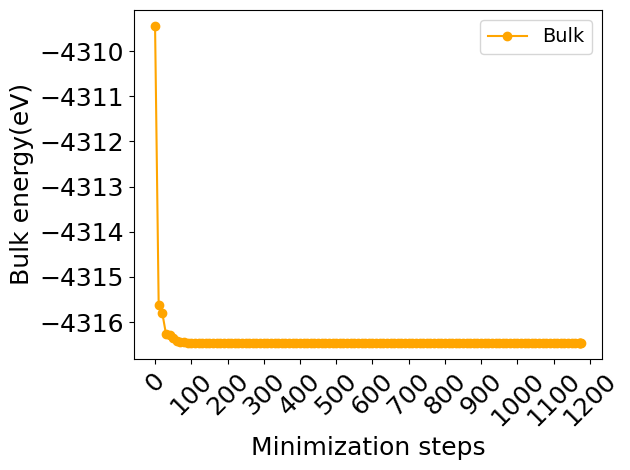


parent_folder:/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_012_02-05-2025_17-03-35/2_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_012_02-05-2025_17-03-35/2_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data
Skipping file 0_print_steps_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data: No repetition found
Confirm file: 0_print_steps_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data
Rep count is []reps

First 10 Step values: [0, 10, 20, 30, 40, 50, 60, 70, 80, 90]
First 10 TotEng values: [-4296.5099, -4308.8695, -4309.1995, -4310.1414, -4310.2305, -4310.2912, -4310.415, -4310.4634, -4310.4727, -4310.4777]


/tmp/ipykernel_25985/621781334.py:335: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="14", loc ="best")


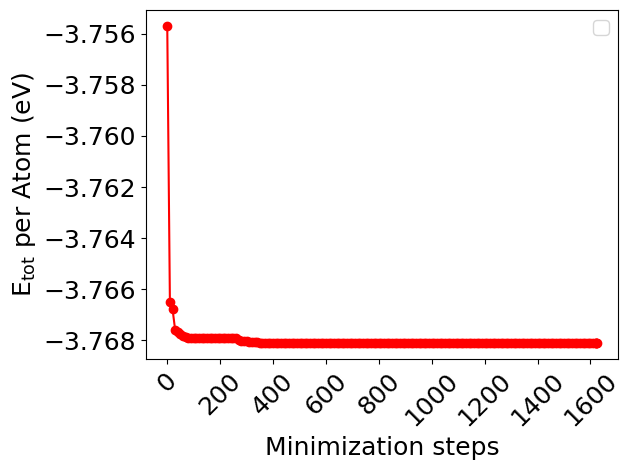

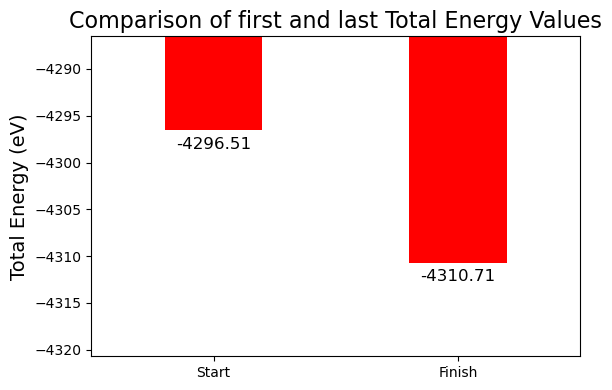

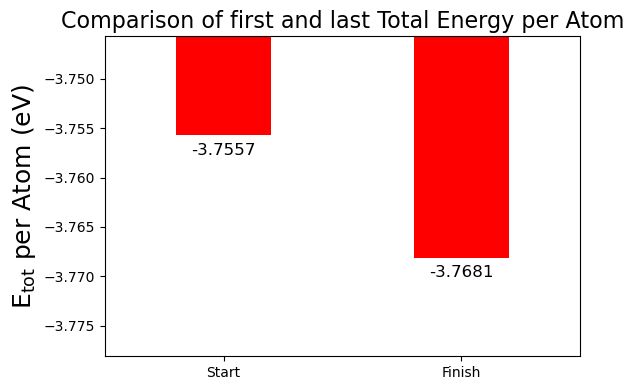

36layers_done


Timestamp:
15-05-2025 17:10


In [11]:
# UP to date 05_05_2025 REWORKED:
#Read stactic relax thermo-data| usefull for Figure 3 --> 012 for opt1 print steps

import pandas as pd
import re

#All-in-one-systematic thermo-calc read:
#rewritten to ask for user input
#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put static relaxation with 0K 
#with E-B reference out of LAMMPS

# Ask the user for the LAMMPS index
LAMMPS_index = '012'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

rep = []
bulk_rep = []
rep_count = []
repeat = []
bulk_repeat = []
n_reps = []

e_pot = []
e_bulk = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt2_thermo_data_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

#WARNING,sorts by timestamp, not name!!!
#causes issue whe editing LAMMPS_Submision
for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    print(f"\nparent_folder:{parent_folder}\n")
    #grandparent_folder = parent_folder.parent
    #print(f"grandparent_folder:{grandparent_folder}")
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        # If the folder does contain "BULK", process the file
     
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            #continue  # Skip if no repetition is found

        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {data_folder.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found

        
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

        atoms1 = read(f"{base_file_path}/optimize1.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        bulk_repeat.append(bulk_rep)
        #if rep_count == repeat[0]:
        #    print(f"Rep count is {rep_count}reps\n")
        #else:
        #    print(f"\nRep count is {rep_count}reps\n")

        # Step 2.1-2.3 readout the "thermo_data.txt"        
        # Define the filename
        #filename = "thermo_data.txt"
        filename = f"{base_file_path}/thermo_data.txt"

        # Initialize lists
        first_column = []
        third_column = []
        
        # Read the file and extract relevant lines
        with open(filename, 'r') as file:
            lines = file.readlines()
        
        # Optional: detect the line with the column headers (could help make parsing robust)
        header_found = False
        for line in lines:
            if re.match(r'\s*Step\s+Temp\s+TotEng\s+PotEng\s+KinEng', line):
                header_found = True
                continue
            if header_found:
                # Match lines with numbers (step, temp, etc.)
                match = re.match(r'\s*(\d+)\s+\S+\s+([-]?\d+\.\d+)', line)
                if match:
                    step = int(match.group(1))
                    toteng = float(match.group(2))
                    first_column.append(step)
                    third_column.append(toteng)
        
        # Output check (optional)
        print("First 10 Step values:", first_column[:10])
        print("First 10 TotEng values:", third_column[:10])
    
    
        # Step 2.4: plot the Energy over the steps
        
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk",color='orange')
        #plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        #plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xticks(np.arange(min(first_column), max(first_column)+100, 100))
        plt.xlabel('Minimization steps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Bulk energy(eV)",fontsize = 18)
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_energy_static_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_static_thermo_data_full.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()
    
        """
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
    
        # Step 2.6: plot the Energy over the Timesteps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"reduced Bulk",color='orange')
        #plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        #plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xticks(np.arange(min(first_column), max(first_column)+100, 100))
        plt.xlabel('Minimization steps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_Bulk_energy_static_thermo_data_cut.png", bbox_inches='tight')
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_Bulk_energy_static_thermo_data_cut.png", bbox_inches='tight')
        plt.show()
        #if rep_count == 2:
        #    plt.show()
        """
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        #print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Bulk_Energy.append(averaged_Energy)
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms1)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

    else:
        # If the folder does not contain "BULK", process the file    
        print(Path(parent_folder))
        data_folder = parent_folder

        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            #continue  # Skip if no repetition is found

        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {data_folder.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found
        
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
        
        atoms1 = read(f"{base_file_path}/optimize1.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        repeat.append(rep)
        
        if rep_count == repeat[0]:
            print(f"Rep count is {rep}reps\n")
        else:
            print(f"\nRep count is {rep}reps\n")
        
        # Step 2.1-2.3 readout the "thermo_data.txt"
        
        # Define the filename
        #filename = "thermo_data.txt"
        filename = f"{base_file_path}/thermo_data.txt"

        # Initialize lists
        first_column = []
        third_column = []
        
        # Read the file and extract relevant lines
        with open(filename, 'r') as file:
            lines = file.readlines()
        
        # Optional: detect the line with the column headers (could help make parsing robust)
        header_found = False
        for line in lines:
            if re.match(r'\s*Step\s+Temp\s+TotEng\s+PotEng\s+KinEng', line):
                header_found = True
                continue
            if header_found:
                # Match lines with numbers (step, temp, etc.)
                match = re.match(r'\s*(\d+)\s+\S+\s+([-]?\d+\.\d+)', line)
                if match:
                    step = int(match.group(1))
                    toteng = float(match.group(2))
                    first_column.append(step)
                    third_column.append(toteng)
        
        # Output check (optional)
        print("First 10 Step values:", first_column[:10])
        print("First 10 TotEng values:", third_column[:10])
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the steps


        #divide by atom count  
        Undivided_Energy = third_column
        Total_Energy_per_atom = []  # You need to initialize the list to store the results
        
        for energy in Undivided_Energy:   
            Divided_Energy = energy / len(atoms1)  # Divide each energy by the length of atoms1
            Total_Energy_per_atom.append(Divided_Energy)  # Append to the result list
            
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            
        #plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Total Energy",color='red')
        plt.plot(np.asarray(first_column),(np.asarray(Total_Energy_per_atom)),marker='o',color='red')
        #plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        #plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xticks(np.arange(min(first_column), max(first_column)+100, 200))
        plt.xlabel('Minimization steps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        #plt.ylabel("Total energy (eV)",fontsize = 18)
        plt.ylabel(r'E$_{\mathrm{tot}}$ per Atom (eV)', fontsize=18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_static_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_static_thermo_data_full.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()

        """
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Steps
        
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label = "Total Energy",color='red')
        #plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        #plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xticks(np.arange(min(first_column), max(first_column)+100, 100))
        plt.xlabel('Minimization steps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_static_thermo_data_cut.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_static_thermo_data_cut.png", bbox_inches='tight') 
        plt.show()
        #if rep_count == 2:
        #    plt.show()

        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms1))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms1)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
        """
        # Extra Step 4: total bar comparison

        # Assuming 'third_column' is already defined
        first_value = third_column[0]
        last_value = third_column[-1]

        # Bar chart setup
        fig, ax = plt.subplots(figsize=(6, 4))

        # Set the bar width (adjust this value to change the thickness)
        bar_width = 0.4  # You can change this value for thicker or thinner bars
        # Set padding (space between bars and the plot's edges)
        left_padding = 1  # Amount of space added to the left of the bars
        right_padding = 1  # Amount of space added to the right of the bars
        #extra_height_padding = 9000  # Add extra space above the highest bar
        extra_height_padding = 0  # Add extra space above the highest bar
        #label_height_offset = 1000  # Change this value to control label height
        #label_height_offset = -100  # Change this value to control label height
        #bar_view_range = 500 # Change this value to control the visible window of the bars
        bar_view_range = 10 # Change this value to control the visible window of the bars
        label_height_offset = -2  # Change this value to control label heigh

        # Positioning the bars with padding
        bar_positions = np.array([0, 1])  # Initial positions for the 'First' and 'Last' bars
        bar_positions += left_padding  # Apply left padding by shifting the positions
        bar_positions[-1] -= right_padding  # Apply right padding by shifting the last bar's position

        # Bar chart (comparing the first and last values)
        bars = ax.bar(['Start', 'Finish'], [first_value, last_value], color=['red', 'red'], width=bar_width)

        # Add labels and title
        ax.set_ylabel('Total Energy (eV)', fontsize=14)
        ax.set_title('Comparison of first and last Total Energy Values', fontsize=16)

        # Get the min and max values (to ensure the plot accommodates negative values)
        y_min = min(first_value, last_value)
        y_max = max(first_value, last_value)

        # Adjust the y-axis limits to focus on a window from 2000 below the min to 2000 above the max
        #y_min_adjusted = y_min - 1000
        #y_max_adjusted = y_max + 1000
        y_min_adjusted = y_min - bar_view_range
        y_max_adjusted = y_max + bar_view_range


        # Set the y-axis limits with the adjusted values
        ax.set_ylim(y_min_adjusted, y_max_adjusted)

        # Adjust the y-axis limits to include both negative and positive values
        #ax.set_ylim(y_min - extra_height_padding, y_max + extra_height_padding)

        # Optional: add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + label_height_offset, round(yval, 2), ha='center', fontsize=12)

        # Adjust the x-axis limits to prevent bars from touching the edges
        ax.set_xlim(-0.5, len(bar_positions) - 0.5)

        # Show the plot
        plt.tight_layout()  # Adjust layout for better spacing
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight')
        plt.show()


        # Extra Step 5: total bar per atom comparison

        # Assuming 'third_column' is already defined
        first_value = Total_Energy_per_atom[0]
        last_value = Total_Energy_per_atom[-1]

        # Bar chart setup
        fig, ax = plt.subplots(figsize=(6, 4))

        # Set the bar width (adjust this value to change the thickness)
        bar_width = 0.4  # You can change this value for thicker or thinner bars
        # Set padding (space between bars and the plot's edges)
        left_padding = 1  # Amount of space added to the left of the bars
        right_padding = 1  # Amount of space added to the right of the bars
        extra_height_padding = 0  # Add extra space above the highest bar
        bar_view_range = 0.01 # Change this value to control the visible window of the bars
        label_height_offset = -0.002  # Change this value to control label heigh
        #XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

        # Positioning the bars with padding
        bar_positions = np.array([0, 1])  # Initial positions for the 'First' and 'Last' bars
        bar_positions += left_padding  # Apply left padding by shifting the positions
        bar_positions[-1] -= right_padding  # Apply right padding by shifting the last bar's position

        # Bar chart (comparing the first and last values)
        bars = ax.bar(['Start', 'Finish'], [first_value, last_value], color=['red', 'red'], width=bar_width)

        # Add labels and title
        plt.ylabel(r'E$_{\mathrm{tot}}$ per Atom (eV)', fontsize=18)
        ax.set_title('Comparison of first and last Total Energy per Atom', fontsize=16)

        # Get the min and max values (to ensure the plot accommodates negative values)
        y_min = min(first_value, last_value)
        y_max = max(first_value, last_value)

        # Adjust the y-axis limits to focus on a window from 2000 below the min to 2000 above the max
        #y_min_adjusted = y_min - 1000
        #y_max_adjusted = y_max + 1000
        y_min_adjusted = y_min - bar_view_range
        y_max_adjusted = y_max + bar_view_range


        # Set the y-axis limits with the adjusted values
        ax.set_ylim(y_min_adjusted, y_max_adjusted)

        # Adjust the y-axis limits to include both negative and positive values
        #ax.set_ylim(y_min - extra_height_padding, y_max + extra_height_padding)

        # Optional: add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + label_height_offset, round(yval, 4), ha='center', fontsize=12)

        # Adjust the x-axis limits to prevent bars from touching the edges
        ax.set_xlim(-0.5, len(bar_positions) - 0.5)

        # Show the plot
        plt.tight_layout()  # Adjust layout for better spacing
        plt.savefig(f"{submission_graph_path}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep_count}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight')
        plt.show()

        if rep:
            print(f"{rep}reps_done\n")
            repeat.append(rep)
        if layer:
            print(f"{layer}layers_done\n")
            layers.append(layer)

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:









#thermo-data MD read:










In [ ]:
#All-in-one-systematic thermo-data read:

Enter the LAMMPS index (e.g., 001, 002, ... etc.):  016


Folder name for 016 is: LAMMPS_Submision_016_14-05-2025_11-41-53
LAMMPS_Submission:
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.mini.data
Skipping file 0_MD_long_CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.mini.data: No repetition found
Confirm file: 0_MD_long_CuGaSe2_BULK_S9_12z-layers_20A-VACUUMS.mini.data
12layers_done

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_016_14-05-2025_11-41-53/8_Submited_mini_data_folders/0_MD_long_CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS.mini.data
Skipping file 0_MD_long_CuGaSe2_BULK_S9_24z-layers_20A-VACUUMS.mini.data: No repetition found
Confirm file: 0_MD_long_CuGaSe2_BULK_S9_24z-layers_20A-

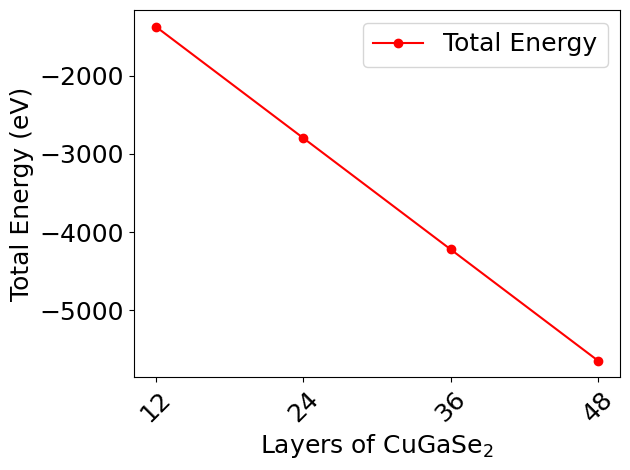

For the Bulk Energy:
For the repetition count: []
The Atom count is: [376, 760, 1144, 1528] (no unit)
The Bulk Energy per atom is: [-3.673821496168335, -3.6895588275386832, -3.6945953815997514, -3.6974845537341343] (in eV per atom)
The Bulk Energy is (orange): [-1381.356882559294, -2804.0647089293993, -4226.6171165501155, -5649.756398105757] (in eV)


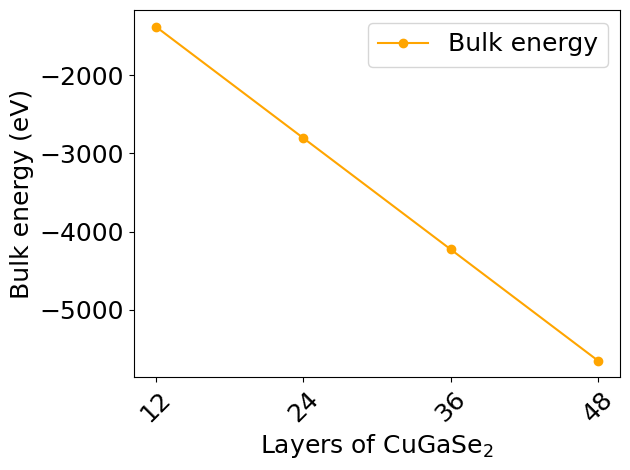


The Total Energies are (red): [-1374.8370523242647, -2797.660238756429, -4220.352288007539, -5642.861502777378] (in eV)
The Bulk energies E_b are (orange): [-1381.356882559294, -2804.0647089293993, -4226.6171165501155, -5649.756398105757] (in eV)


/tmp/ipykernel_5529/4216626047.py:1176: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


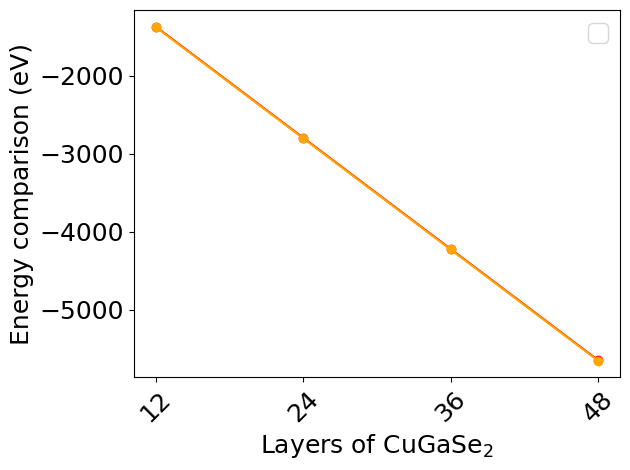


Testing:
The Total energies per atom are: [-3.656481522139002, -3.6811318931005643, -3.689119132873723, -3.69297218768153]
The Bulk energies per Atom are: [-3.673821496168335, -3.6895588275386832, -3.6945953815997514, -3.6974845537341343] (in eV per Atom)
The Energy difference per Atom is: [0.01733997402933296, 0.008426934438118927, 0.0054762487260284765, 0.0045123660526043] (in eV per Atom)
The Energy difference is: [6.519830235029193, 6.404470172970385, 6.264828542576577, 6.89489532837937] (in eV)
The Energy difference per Area of the GB is: [0.04147831959011252, 0.04074441374448139, 0.03985603169084457, 0.04386443537047292] (in eV/Å²)
The Energy difference per Area of the GB is: [0.6645573408088647, 0.6527988481313319, 0.6385653685443735, 0.702787210618643] (in J/m²)
The Energy difference is: [6.519830235029193, 6.404470172970385, 6.264828542576577, 6.89489532837937] (in eV)


/tmp/ipykernel_5529/4216626047.py:1240: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


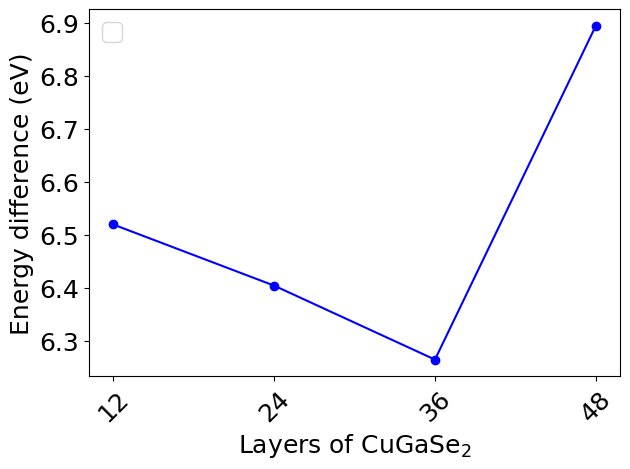



The Total energies per atom are (red): [-3.656481522139002, -3.6811318931005643, -3.689119132873723, -3.69297218768153] (in eV per Atom)
The Bulk energies per Atom are (orange): [-3.673821496168335, -3.6895588275386832, -3.6945953815997514, -3.6974845537341343] (in eV per Atom)


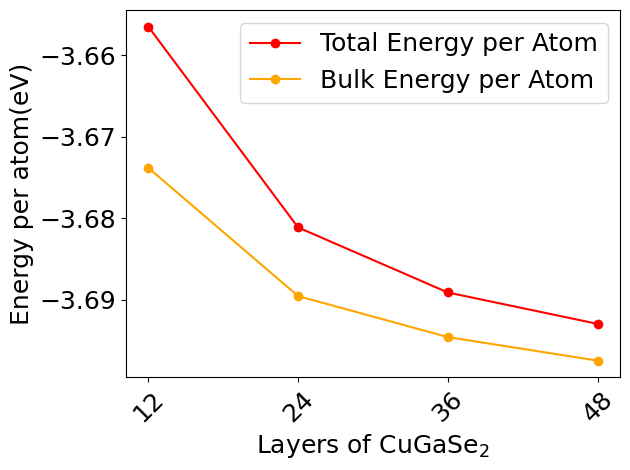

The Energy difference per Atom is: [0.01733997402933296, 0.008426934438118927, 0.0054762487260284765, 0.0045123660526043] (in eV)


/tmp/ipykernel_5529/4216626047.py:1313: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


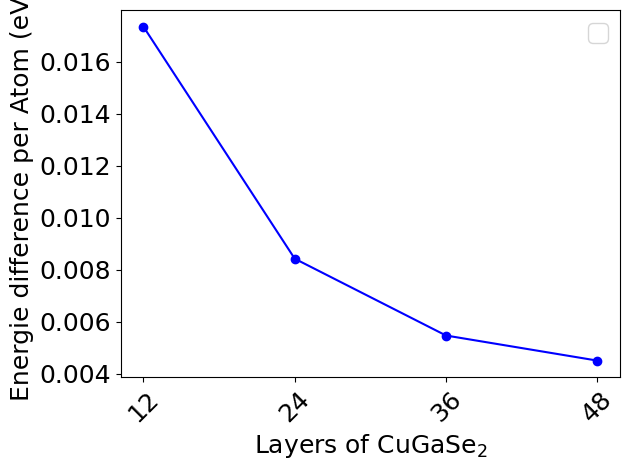



The formation energies are: [0.664557340808876, 0.6527988481313313, 0.6385653685443811, 0.7027872106186858]


/tmp/ipykernel_5529/4216626047.py:1349: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize="18", loc ="best")


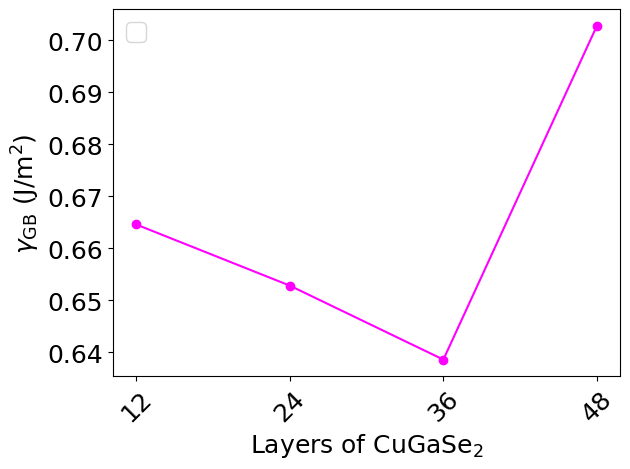

Formation_energy_half_v2


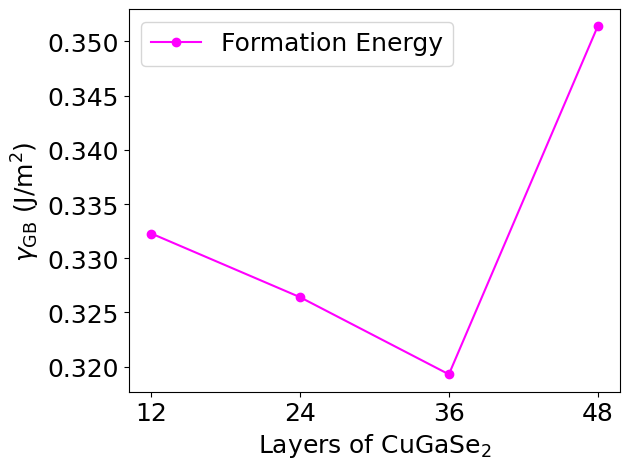


Timestamp:
19-05-2025 14:10


In [34]:
##### UP to date 05_05_2025 NEW SYSTEM COMPATIBLE:
#Read thermo-data| usefull for Figure 4 --> 015 for opt2 long MD

#All-in-one-systematic thermo-calc read:
#rewritten to ask for user input
#Calculating the formation energy γ_GB of a GB (with 20Å Vacuum on both sides) that has been put through MD at 1000K 
#with E-B reference out of LAMMPS

# Ask the user for the LAMMPS index
#LAMMPS_index = '009'
#LAMMPS_index = '015'
LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")

# Define the base directory
base_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data"

# Clear preexisting variables: (needs to be cleaned up)
# new
first_column = []
third_column = []
first_column_no_startup = []
third_column_no_startup = []

#carry over:
Formation_Energy = []

rep = []
bulk_rep = []
repeat = []
bulk_repeat = []
layer = []
layers = []
bulk_layer = []
bulk_layers = []
n_reps = []

e_pot = []
e_bulk = []
Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []

Ediff = []
Ediff_per_area = []
Ediff_per_atom = []
Ediff_per_area_inJ = []

# Path of the base directory
base_path = Path(base_dir)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_opt2_thermo_data_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

#WARNING,sorts by timestamp, not name!!!
#causes issue whe editing LAMMPS_Submision
for folder in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*"):
    # Get the parent directory of the file
    parent_folder = folder.parent
    #grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    #if "BULK" in grandparent_folder.name:
    if "BULK" in parent_folder.name:
        # If the folder does contain "BULK", process the file
     
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            bulk_rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            #continue  # Skip if no repetition is found

        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            bulk_layer = int(layer_str)
            print(f"Confirm file: {data_folder.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found

        if bulk_rep:
            bulk_repeat.append(bulk_rep)
        if bulk_layer:
            bulk_layers.append(bulk_layer)

        
        
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file

        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        #print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")

        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
    
        # Step 2.4: plot the Energy over the Timesteps
        """
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="best")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Bulk energy(eV)",fontsize = 18)
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.show()  
        """
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
    
        # Step 2.6: plot the Energy over the Timesteps
        """
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{bulk_rep}reps",color='orange')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Bulk energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight')
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_energy_thermo_data_cut.png", bbox_inches='tight')
        plt.show()
        """
        
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        #print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Bulk_Energy.append(averaged_Energy)
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Bulk_Energy_per_atom.append(Divided_Energy)
        #print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

        #Extra Step:
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        # Add the new variable to store temperatures
        second_column = []  # Create an empty list to store the second column (Temperature)

        # Step 2.2: Read the second column (Temperature) of the .csv file starting from the second row
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns (timesteps, temperature, energy)
                    try:
                        # Convert the 2nd column value (Temperature) to float and append to the list
                        second_column.append(float(row[1]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[1]} to a float. Skipping it.")

        # Output the second column (Temperature) as a list
        # print(second_column)
        list_length = len(second_column)
        # print(f"The length of the second_column list is: {list_length}")

        #Extra Step 2: Plot the Temperature over the Timesteps
        """#v1
        plt.plot(np.asarray(first_column), np.asarray(second_column), marker='o', label=f"Temperature", color='green')
        plt.grid(True)
        plt.legend(fontsize="14", loc="best")
        plt.xticks(rotation=45)
        plt.xticks(fontsize=18)
        plt.xticks(np.arange(min(first_column) - 100, max(first_column) + 4000, 4000))
        plt.xlabel('Timesteps', fontsize=18)
        plt.yticks(fontsize=18)
        plt.ylabel('Temperature (K)', fontsize=18)  # Temperature in Kelvin
        plt.tight_layout()

        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """

        """#v2
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        time_in_ps = np.array(first_column) * 0.001  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first
        # Display only every nth timestep label on the second x-axis (e.g., every 2nd timestep)
        n = 1000  # Change this value to display every nth label
        ticks_to_display = first_column[::n]  # Select every nth timestep
        time_labels = time_in_ps[::n]  # Corresponding time labels in ps
        ax2.set_xticks(ticks_to_display)
        ax2.set_xticklabels([f"{t:.3f}" for t in time_labels])  # Format time labels to 3 decimal places
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """

        #do not uncomment this one
        """
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Create a second y-axis (right side) for Bulk Energies
        ax3 = ax1.twinx()  # This shares the same x-axis but adds a new y-axis on the right

        # Plot Bulk Energies
        ax3.plot(first_column, third_column, marker='o', label="Bulk Energies", color='orange')

        # Customize second y-axis (right side)
        ax3.set_ylabel('Bulk Energy (eV)', fontsize=18)
        ax3.tick_params(axis='y', labelsize=14)
        #ax3.set_ylabel('Bulk Energy (units)', fontsize=18, color='orange')
        #ax3.tick_params(axis='y', labelsize=14, labelcolor='orange')

        # Optional: add second legend (if you want both legends)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_3, labels_3 = ax3.get_legend_handles_labels()
        #ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='best', fontsize=14)
        ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='lower right', fontsize=14)


        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        
        #NEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWER
        """
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        #ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_Temperature_solo_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk__Temperature_solo_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        
        #-----------------------------------------------------------------------------------------------------------------------------

        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Bulk Energy vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Bulk Energy", color='orange')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Bulk Energies (eV)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        #ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_Bulk_Eneries_wide_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_Bulk_Eneries_wide_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWER
        
        if bulk_rep:
            print(f"{bulk_rep}reps_done\n")
        if bulk_layer:
            print(f"{bulk_layer}layers_done\n")  

    else:
        # If the folder does not contain "BULK", process the file    
        print(Path(parent_folder))
        data_folder = parent_folder
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        match = re.search(r'(\d+)rep.*\.data$', data_folder.name)
        if match:
            rep_str = match.group(1)  # Extract the repetition value (e.g., 2)
            rep = int(rep_str)
            #print(f"\n\nFIX ME PLEASE:{bulk_rep}")
        else:
            print(f"Skipping file {data_folder.name}: No repetition found")
            #continue  # Skip if no repetition is found

        #match = re.search(r'(\d+)z-layers.*\.data$', data_folder.name)
        match2 = re.search(r'(\d+)z-layers?.*\.data$', data_folder.name)
        if match2:
            layer_str = match2.group(1)  # Extract the z-layer value (e.g., 12)
            layer = int(layer_str)
            print(f"Confirm file: {data_folder.name}")
        else:
            print(f"Skipping layer based files: No layer count found")
            #continue  # Skip if no layer count is found

        if rep:
            repeat.append(rep)
        if layer:
            layers.append(layer)
        
        base_file_path = Path(folder)
        #print(f"Base_file_path: {base_file_path}")
        txt_file_path = f"{base_file_path}/thermo_data.txt"  # Path to the .txt file
        csv_file_path = f"{base_file_path}/thermo_data.csv"  # Path to save the .csv file
        
        atoms2 = read(f"{base_file_path}/optimize2.data", format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
        #repeat.append(rep)
        
        # Step 2.1: Convert .txt to .csv
        with open(txt_file_path, 'r') as txt_file:
            lines = txt_file.readlines()
        # Use builtins' open to avoid IPython file handle restrictions
        import builtins
        # Create an empty CSV file
        with builtins.open(csv_file_path, mode='w', newline='') as file:
            csv_writer = csv.writer(file)
        print(f"Empty CSV file created at {csv_file_path}")
        
        # Open a new CSV file to write the converted content
        with open(csv_file_path, mode='w', newline='') as csv_file:
            csv_writer = csv.writer(csv_file)    
            # Iterate through each line of the .txt file
            for line in lines:
                # Assuming space or tab separation, split line by whitespace
                row = line.split()  # Adjust this if using different delimiters (e.g., line.split('\t') for tabs)
                csv_writer.writerow(row)
        
        # Step 2.2: Read the first column of the .csv file starting from the second row
        first_column = []  # Create an empty list to store the first column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 1st column value to an integer and append to the list
                        first_column.append(int(row[0]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid integer), skip that value
                        print(f"Warning: Could not convert {row[0]} to an integer. Skipping it.")
        
        # Output the first column as a list
        #print(first_column)
        list_length = len(first_column)
        #print(f"The length of the first_column list is: {list_length}")
        #print("\n")
    
        # Step 2.3: Read the third column of the .csv file starting from the second row
        third_column = []  # Create an empty list to store the third column
        
        with open(csv_file_path, mode='r') as file:
            csv_reader = csv.reader(file)
            # Skip the header (1st row)
            next(csv_reader)
            # Iterate through the rows starting from the 2nd row
            for row in csv_reader:
                if len(row) >= 3:  # Ensure the row has at least 3 columns
                    try:
                        # Convert the 3rd column value to a float and append to the list
                        third_column.append(float(row[2]))
                    except ValueError:
                        # In case the conversion fails (e.g., if it's not a valid float), skip that value
                        print(f"Warning: Could not convert {row[2]} to a float. Skipping it.")
        
        # Output the third column as a list (contains Total Energy of the Supercell in eV)
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
    
        
        # Step 2.4: plot the Energy over the Timesteps
        """    
        plt.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel("Total energy(eV)",fontsize = 18)
        plt.tight_layout()
    
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_full.png", bbox_inches='tight') 
        plt.show()
        """
        # Step 2.5: cut out the first 10 steps to reduce the spread
        
        #print(first_column)
        list_length = len(first_column)
        #print("Cutting startup:")
        #print(f"The length of the first_column list is: {list_length}")
        # Remove the first 10 entries
        first_column_no_startup = first_column[10:]
        # Print the updated list length
        list_length = len(first_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {first_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        #print("\n")
        #print(third_column)
        list_length = len(third_column)
        #print(f"The length of the third_column list is: {list_length}")
        # Remove the first 10 entries
        third_column_no_startup = third_column[10:]
        # Print the updated list length
        list_length = len(third_column_no_startup)
        #print(f"Updated list after removing the first 10 entries: {third_column_no_startup}")
        #print(f"The new length of the first_column list is: {list_length}")
        
        
        # Step 2.6: plot the Energy over the Timesteps
        """
        plt.plot(np.asarray(first_column_no_startup),(np.asarray(third_column_no_startup)),marker='o',label=f"{rep}reps",color='red')
        plt.grid(True)
        plt.legend(fontsize="14", loc ="lower right")
        plt.xticks(rotation=45) 
        plt.xticks(fontsize = 18) 
        plt.xticks(np.arange(min(first_column)-100, max(first_column)+4000, 4000))
        plt.xlabel('Timesteps',fontsize = 18)
        plt.yticks(fontsize = 18) 
        plt.ylabel('Total energy(eV)',fontsize = 18) #Total energy (in eV) of the Supercell
        plt.tight_layout()
        
        # Show the plot
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_energy_thermo_data_cut.png", bbox_inches='tight') 
        plt.show()
        """
        # Step 2.7: Avarage the energy
        
        # Calculate the average
        averaged_Energy = sum(third_column_no_startup) / len(third_column_no_startup) if third_column_no_startup else 0  # Avoid division by zero if the list is empty
        print(f"The average of the Energy is: {averaged_Energy} in eV")
        Undivided_Energy = averaged_Energy
    
        Total_Energy.append(averaged_Energy)
        n_reps.append(len(atoms2))
    
        # Step 2.8 divide by atom count (needed?)
        
        Divided_Energy = Undivided_Energy/len(atoms2)
        Total_Energy_per_atom.append(Divided_Energy)
        print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")

        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        """
        #Extra Step 2: Plot the Temperature over the Timesteps
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Create a second y-axis (right side) for Bulk Energies
        ax3 = ax1.twinx()  # This shares the same x-axis but adds a new y-axis on the right

        # Plot Bulk Energies
        ax3.plot(first_column, third_column, marker='o', label="Total Energies", color='red')

        # Customize second y-axis (right side)
        ax3.set_ylabel('Total Energy (eV)', fontsize=18)
        ax3.tick_params(axis='y', labelsize=14)
        #ax3.set_ylabel('Bulk Energy (units)', fontsize=18, color='orange')
        #ax3.tick_params(axis='y', labelsize=14, labelcolor='orange')

        # Optional: add second legend (if you want both legends)
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_3, labels_3 = ax3.get_legend_handles_labels()
        #ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='best', fontsize=14)
        ax1.legend(lines_1 + lines_3, labels_1 + labels_3, loc='lower right', fontsize=14)
        
        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_GB_Temperature_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_GB_Temperature_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        """
        #Extra Step 3: Plot the Energies over the Timesteps AND Time
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, third_column, marker='o', label="Total Energies", color='red')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        #ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)
      
        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_GB_Total_Energies_time_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_GB_Total_Energies_time_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW
        """
        # Extra Step 4: total bar comparison

        # Assuming 'third_column' is already defined
        first_value = third_column[0]
        last_value = third_column[-1]

        # Bar chart setup
        fig, ax = plt.subplots(figsize=(6, 4))

        # Set the bar width (adjust this value to change the thickness)
        bar_width = 0.4  # You can change this value for thicker or thinner bars
        # Set padding (space between bars and the plot's edges)
        left_padding = 1  # Amount of space added to the left of the bars
        right_padding = 1  # Amount of space added to the right of the bars
        #extra_height_padding = 9000  # Add extra space above the highest bar
        extra_height_padding = 0  # Add extra space above the highest bar
        #label_height_offset = 1000  # Change this value to control label height
        label_height_offset = -100  # Change this value to control label height
        bar_view_range = 500 # Change this value to control the visible window of the bars

        # Positioning the bars with padding
        bar_positions = np.array([0, 1])  # Initial positions for the 'First' and 'Last' bars
        bar_positions += left_padding  # Apply left padding by shifting the positions
        bar_positions[-1] -= right_padding  # Apply right padding by shifting the last bar's position

        # Bar chart (comparing the first and last values)
        bars = ax.bar(['Start', 'Finish'], [first_value, last_value], color=['red', 'red'], width=bar_width)

        # Add labels and title
        ax.set_ylabel('Total Energy in [eV]', fontsize=14)
        ax.set_title('Comparison of first and last Total Energy Values', fontsize=16)

        # Get the min and max values (to ensure the plot accommodates negative values)
        y_min = min(first_value, last_value)
        y_max = max(first_value, last_value)

        # Adjust the y-axis limits to focus on a window from 2000 below the min to 2000 above the max
        #y_min_adjusted = y_min - 1000
        #y_max_adjusted = y_max + 1000
        y_min_adjusted = y_min - bar_view_range
        y_max_adjusted = y_max + bar_view_range



        # Set the y-axis limits with the adjusted values
        ax.set_ylim(y_min_adjusted, y_max_adjusted)

        # Adjust the y-axis limits to include both negative and positive values
        #ax.set_ylim(y_min - extra_height_padding, y_max + extra_height_padding)

        # Optional: add values on top of bars
        for bar in bars:
            yval = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, yval + label_height_offset, round(yval, 2), ha='center', fontsize=12)

        # Adjust the x-axis limits to prevent bars from touching the edges
        ax.set_xlim(-0.5, len(bar_positions) - 0.5)

        # Show the plot
        plt.tight_layout()  # Adjust layout for better spacing
        plt.savefig(f"{submission_graph_path}/{rep}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_ref_GB_Total_Energies_Box_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEWNEW

        #NEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWER
        """
        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Temperature vs. Timesteps (primary x-axis)
        ax1.plot(first_column, second_column, marker='o', label="Temperature", color='darkred')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Temperature (K)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        #ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_GB_Temperature_solo_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_GB_Temperature_solo_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        
        #-----------------------------------------------------------------------------------------------------------------------------

        # Convert timesteps to time in picoseconds (1 timestep = 0.001 ps)
        #include  ax3.plot(np.asarray(first_column),(np.asarray(third_column)),marker='o',label="Bulk_Enegies",color='orange')
        # with descripton on the right side?
        #v3
        time_in_ps = np.array(first_column) * 0.001  # Time in ps
        #time_in_ps = (np.array(first_column) * 0.001).astype(int)  # Time in ps

        # Create the plot
        fig, ax1 = plt.subplots(figsize=(10, 6))

        # Plot Bulk Energy vs. Timesteps (primary x-axis)
        ax1.plot(first_column, third_column, marker='o', label="Total Energy", color='red')
        ax1.set_xlabel('Timesteps', fontsize=18)
        ax1.set_ylabel('Total Energies (eV)', fontsize=18)
        ax1.tick_params(axis='x', labelsize=14)
        ax1.tick_params(axis='y', labelsize=14)
        #ax1.grid(True)
        ax1.legend(loc='best', fontsize=14)

        # Create a second x-axis (actual time in ps)
        ax2 = ax1.twiny()  # twiny() creates a second x-axis at the top
        ax2.set_xlim(ax1.get_xlim())  # Make sure the limits of the second x-axis match the first

        # Specific time points to display (in ps)
        specific_time_values = [0, 10, 20, 30, 40, 50]  # Example specific timepoints in ps
        #specific_time_values = [0, 200, 400, 600, 800, 1000]  # Example specific timepoints in ps LONG_MD_Ver

        # Convert these specific times into timesteps (since 1 timestep = 0.001 ps, so timestep = time / 0.001)
        specific_timestep_values = (np.array(specific_time_values) / 0.001).astype(int)

        # Filter the specific time values that fall within the range of the available timesteps
        valid_timepoints = []
        valid_timesteps = []

        for time, timestep in zip(time_in_ps, first_column):
            if time in specific_time_values:
                valid_timepoints.append(time)
                valid_timesteps.append(timestep)

        # Set the ticks and labels for the second x-axis (only for valid timepoints)
        ax2.set_xticks(valid_timesteps)
        ax2.set_xticklabels([f"{t:.0f}" for t in valid_timepoints])  # Format time labels to 0 decimal places
        #ax2.set_xticklabels([f"{t:.3f}" for t in valid_timepoints])  # Format time labels to 3 decimal places
        #ax2.set_xticklabels([str(t) for t in valid_timepoints])
        ax2.set_xlabel('Time (ps)', fontsize=18)

        # Show the plot
        plt.tight_layout()
        plt.savefig(f"{submission_graph_path}/{rep}rep_Total_Eneries_wide_thermo_data_full.png", bbox_inches='tight') 
        plt.savefig(f"{common_graph_folder}/{rep}rep_Total_Eneries_wide_thermo_data_full.png", bbox_inches='tight')
        plt.show()
        """
        #NEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWERNEWER
        
        if rep:
            print(f"{rep}reps_done\n")
        if layer:
            print(f"{layer}layers_done\n")

# Step 3:  calculate formation energy for each repetition

xAg = 0
#A = 157.30529027915497
#print(f"\nThe Area of the GB is: {A} (in Å²)")
a, b = atoms2.cell[0], atoms2.cell[1]
A = np.linalg.norm(np.cross(a,b))
print(f"The Area of the GB is: {A} (in Å²)")

"""
#sort:
#print(repeat)
repeat = sorted(repeat)
#print(repeat)
#print(n_reps)
n_reps = sorted(n_reps)
#print(n_reps)
#print(Bulk_Energy)
Bulk_Energy = sorted(Bulk_Energy, reverse = True)
#print(Bulk_Energy)
Total_Energy = sorted(Total_Energy, reverse = True)
"""

#sort bulk energy
print(Bulk_Energy)
Bulk_Energy = sorted(Bulk_Energy, reverse = True)
print(Bulk_Energy)
               
# Loop over the energies and calculate formation energy
for i in range(4):
    eform = (((Total_Energy[i] - (Bulk_Energy[i])) / (1 * A))* 16.0218)
    #1 Fläche von interesse nur die KG da 2 Oberflächen auch in ref E_bulk gebildet werden
    #16.0218 Conversion factor from eV/Å² to J/m²
    Formation_Energy.append(eform)                                                   

# Step 4: print values for the Total Energy of the GB (later in comparison to the bulk energies):

print("\nFor the Total Energy of the GB:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Total Energy per atom is: {Total_Energy_per_atom} (in eV per atom)")
print(f"The Total Energy is (red): {Total_Energy} (in eV)")

# Step 5: plot Total energy per atom over repetitions of the supercell
"""
plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
plt.grid(True)
plt.legend(fontsize="18", loc ="best")
plt.xticks(rotation=45) 
plt.xticks(fontsize = 18) 
plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
plt.xlabel('Repetitions',fontsize = 18)
plt.yticks(fontsize = 18) 
plt.ylabel('Total Energy in eV',fontsize = 18)
plt.tight_layout()
"""

if repeat:
    plt.plot(np.asarray(repeat),np.asarray(Total_Energy),marker='o',label='',color='red')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),np.asarray(Total_Energy),marker='o',label='Total Energy',color='red')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Total Energy (eV)',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Total_Energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 9: print values for the Bulk Energy

print("For the Bulk Energy:")
print(f"For the repetition count: {repeat}")
print(f"The Atom count is: {n_reps } (no unit)")
print(f"The Bulk Energy per atom is: {Bulk_Energy_per_atom} (in eV per atom)")
print(f"The Bulk Energy is (orange): {Bulk_Energy} (in eV)")

# Step 10: plot BULK energy over repetitions of the supercell

if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('BULK energy (eV)',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Bulk_Energy)),marker='o',label='Bulk energy',color='orange')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Bulk energy (eV)',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/ref_Bulk_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()

# Step 6: plot comparison: Total energy and Bulk energy over repetitions of the supercell

print(f"\nThe Total Energies are (red): {Total_Energy} (in eV)")
print(f"The Bulk energies E_b are (orange): {Bulk_Energy} (in eV)")

if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Total_Energy)),marker='o',label='',color='red')
    plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energy comparison in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Total_Energy)),marker='o',label='',color='red')
    plt.plot(np.asarray(layers),(np.asarray(Bulk_Energy)),marker='o',label='',color='orange')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energy comparison (eV)',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/Energy_comparison_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Step 7: Testing calculations:

#Testing:
#KEIN fehler in der Formel !!!

#for i in range(4):
#    Bulk_Energy_per_atom.append(Bulk_Energy[i]/n_reps[i]) #alredy done in step 2!
print(f"\nTesting:\nThe Total energies per atom are: {Total_Energy_per_atom}")    
print(f"The Bulk energies per Atom are: {Bulk_Energy_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff_per_atom.append(Total_Energy_per_atom[i]-Bulk_Energy_per_atom[i])

print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV per Atom)")

for i in range(4):
    Ediff.append(n_reps[i] * Ediff_per_atom[i])

print(f"The Energy difference is: {Ediff} (in eV)")

for i in range(4):
    Ediff_per_area.append(Ediff[i]/(1*A))

print(f"The Energy difference per Area of the GB is: {Ediff_per_area} (in eV/Å²)")

for i in range(4):
    Ediff_per_area_inJ.append(Ediff_per_area[i]*16.0218)

print(f"The Energy difference per Area of the GB is: {Ediff_per_area_inJ} (in J/m²)")

print(f"The Energy difference is: {Ediff} (in eV)")

# Step 8: plot Ediff over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Ediff)),marker='o',label='',color='blue')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energie difference in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Ediff)),marker='o',label='',color='blue')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energy difference (eV)',fontsize = 18)
    plt.tight_layout()
    
# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_difference_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()

print("\n")
print(f"The Total energies per atom are (red): {Total_Energy_per_atom} (in eV per Atom)")
print(f"The Bulk energies per Atom are (orange): {Bulk_Energy_per_atom} (in eV per Atom)")

# Step 9: plot comparison Total energy per atom and Bulk energy per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Total_Energy_per_atom)),marker='o',label='',color='red')
    plt.plot(np.asarray(repeat),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='',color='orange')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energy per atom comparison in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Total_Energy_per_atom)),marker='o',label='Total Energy per Atom',color='red')
    plt.plot(np.asarray(layers),(np.asarray(Bulk_Energy_per_atom)),marker='o',label='Bulk Energy per Atom',color='orange')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energy per atom(eV)',fontsize = 18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_comparison_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


print(f"The Energy difference per Atom is: {Ediff_per_atom} (in eV)")

# Step 10: plot Ediff per atom over repetitions of the supercell
if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energie difference per Atom in eV',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Ediff_per_atom)),marker='o',label='',color='blue')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18)
    #plt.xticks(layers)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('Energie difference per Atom (eV)',fontsize = 18)
    plt.tight_layout()
    
# Show the plot
plt.savefig(f"{submission_graph_path}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/Energy_difference_per_Atom_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.show()


# Step 11: plot formation energy over repetitions of the supercell:

print("\n")
print(f"The formation energies are: {Formation_Energy}")
if repeat:
    plt.plot(np.asarray(repeat),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
    plt.grid(True)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)',fontsize = 18)
    plt.xlabel('Repetitions',fontsize = 18)
    plt.yticks(fontsize = 18) 
    plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers),(np.asarray(Formation_Energy)),marker='o',label='',color='magenta')
    plt.grid(False)
    plt.legend(fontsize="18", loc ="best")
    plt.xticks(rotation=45) 
    plt.xticks(fontsize = 18) 
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    #plt.xlabel('Layers of CuGaSe2',fontsize = 18)
    plt.yticks(fontsize = 18) 
    #plt.ylabel('GB Formation energy (J/m$^2$)',fontsize = 18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight')
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

print("Formation_energy_half_v2")

Formation_Energy_half = []
for i in range(4):
    Formation_Energy_half.append(Formation_Energy[i] * (1/2))

if repeat:
    plt.plot(np.asarray(repeat), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    #plt.grid(True)
    plt.legend(fontsize=18, loc="best")
    plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(repeat)-1, max(repeat)+1, 1))
    plt.xlabel('Repetitions ($\AA$)', fontsize=18)
    #plt.ylabel('GB Formation energy in [J/m$^2$]', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional: dynamic y-axis tick range
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()
else:
    plt.plot(np.asarray(layers), np.asarray(Formation_Energy_half), marker='o', label='Formation Energy', color='magenta')
    plt.grid(False)
    plt.legend(fontsize=18, loc="best")
    #plt.xticks(rotation=45)
    plt.xticks(fontsize=18)
    plt.xticks(np.arange(min(layers), max(layers)+1, layers[0]))
    #plt.xlabel('Layers of CuGaSe2 ($\AA$)', fontsize=18)
    plt.xlabel("Layers of CuGaSe"r'$_{\mathrm{2}}$', fontsize=18)
    plt.ylabel(r'$\gamma_{\mathrm{GB}}$ (J/m$^2$)', fontsize=18)
    plt.yticks(fontsize=18)
    # Optional dynamic ticks again
    # plt.yticks(np.arange(min(Formation_Energy)-0.005, max(Formation_Energy)+0.005, 0.005))
    plt.tight_layout()

# Show the plot
plt.savefig(f"{submission_graph_path}/GB_Formation_energy_scale2_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/GB_Formation_energy_scale2_thermo_data_E_B_from_LAMMPS.png", bbox_inches='tight') 
plt.show()

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

In [ ]:









#GB opt1 energy over distance read:

#OPEN OPEN OPEN OPEN OPEN!!!!!!!!!!!!!!!!








Folder name for 011 is: LAMMPS_Submision_011_23-04-2025_22-48-13
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos10-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data


/nfshome/okresa/anaconda3/envs/ASE_pyace_aimsgb/lib/python3.9/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
/tmp/ipykernel_25985/3338748261.py:171: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4443.240778640902 eV
The Energy (per atom) is: -3.883951729581208 in eV per atom
Position: Pos10
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos10-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos12-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-4443.240943169932 eV
The Energy (per atom) is: -3.88395187340029 in eV per atom
Position: Pos12
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S

/tmp/ipykernel_25985/3338748261.py:118: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4440.3170272927755 eV
Undivided_Energy-4440.3170272927755
The Energy (per atom) is: -3.8847917999061905 in eV per atom
Position: Pos1
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos1-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos2-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-4440.534307371306 eV
Undivided_Energy-4440.534307371306
The Energy (per atom) is: -3.884981896212866 in eV per atom
Position: Pos2
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAM

/tmp/ipykernel_25985/3338748261.py:223: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-4444.533780490715 eV
The Energy (per atom) is: -3.885081975953422 eV per atom
36 layers done

ref DONE
##############################################################################################################################

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos15-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-4443.2410008636325 eV
The Energy (per atom) is: -3.8839519238318467 in eV per atom
Position: Pos15
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos15-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Int

2025-05-15 17:16:47,920 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:16:47,921 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Supercell potential Energy:
-4440.1749767181645 eV
Undivided_Energy-4440.1749767181645
The Energy (per atom) is: -3.8846675211882453 in eV per atom
Position: Pos24
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_011_23-04-2025_22-48-13/98_Submited_mini_data_folders/0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos24-Vac.mini.data
No Ref in folder name found


vac_energies_dict:
defaultdict(<class 'list'>, {'1': [-4440.3170272927755], '2': [-4440.534307371306], '3': [-4440.5684055406555], '4': [-4440.572520847703], '5': [-4440.5740265833965], '6': [-4440.57230805049], '7': [-4440.571907903796], '8': [-4440.5715291833885], '9': [-4440.571334390892], '10': [-4440.571261143453], '11': [-4440.571228749321], '12': [-4440.5712150125555], '13': [-4440.571207875693], '14': [-4440.571202949818], '15': [-4440.571195307789], '16': [-4440.571185435673], '17': [-4440.571186119363], '18': [-4440.571154

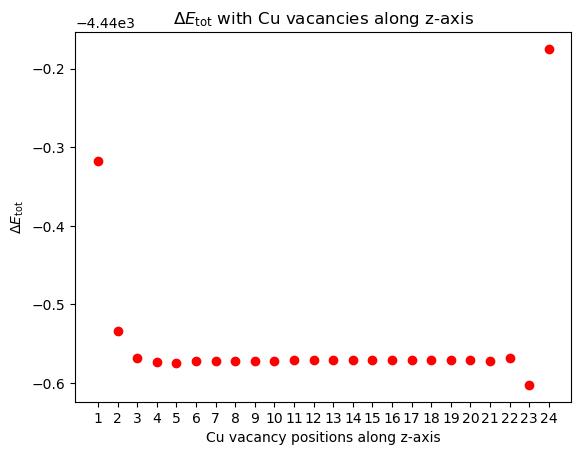

2025-05-15 17:16:48,119 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl plot:


2025-05-15 17:16:48,119 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


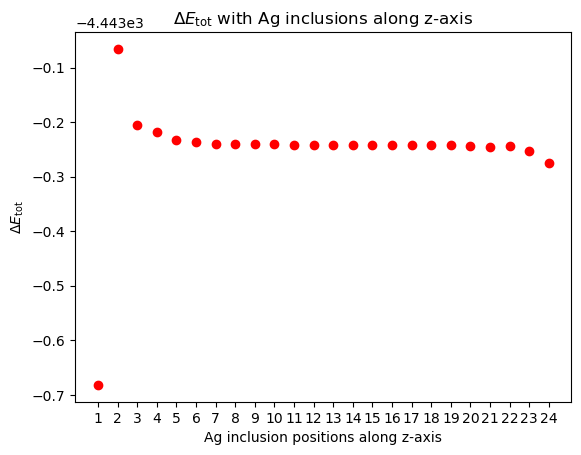

2025-05-15 17:16:48,310 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:16:48,310 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


Energy_Delta_incl: [1.2930018498127538, 1.292837320783292, 1.292808103090465, 0.8519005605203347, 1.4683163432555375, 1.3296237841568654, 1.3157034840078268, 1.3005828222630953, 1.2969710350180321, 1.2946607748899623, 1.2938325861496196, 1.293225853972217, 1.2928776629678396, 1.2927947971011235, 1.292779627082382, 1.292733635767945, 1.2926378967122218, 1.2925755911210217, 1.2923751916441688, 1.2911104052845985, 1.2883260565122328, 1.2894860949263602, 1.2803827972174986, 1.2594317188468267];
24 Energy_Delta_incl list entrys
Energy_Delta_Vac: [4.216753197939397, 3.999473119409231, 3.965374950059413, 3.9612596430115445, 3.9597539073183725, 3.9614724402244974, 3.9618725869186164, 3.962251307326369, 3.962446099822955, 3.9625193472620595, 3.962551741394236, 3.9625654781593767, 3.9625726150215996, 3.9625775408967456, 3.9625851829259773, 3.9625950550416746, 3.96259437135177, 3.962626295076916, 3.9627991712959556, 3.9633631437882286, 3.9624387856683825, 3.9659869265933594, 3.9314714420588643, 4

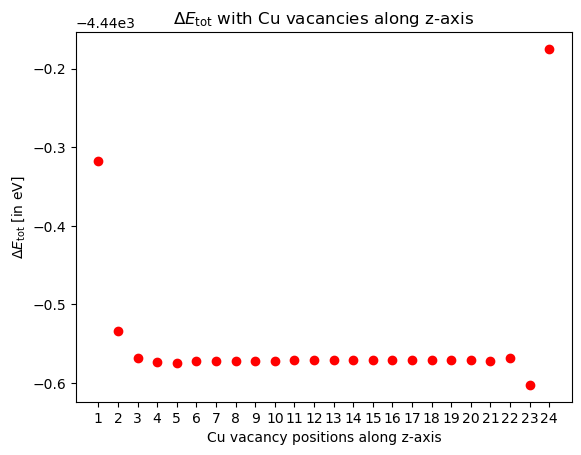

sorted_Total_Energy_Vac distance to GB plot:


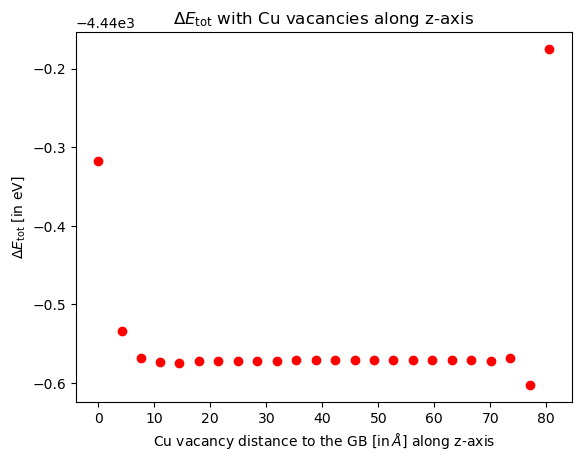

2025-05-15 17:16:48,510 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:16:48,511 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl positions along z-axis plot:


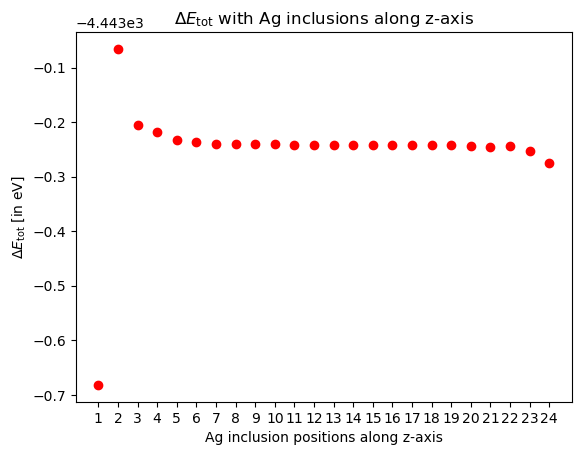

sorted_Total_Energy_incl distance to GB plot:


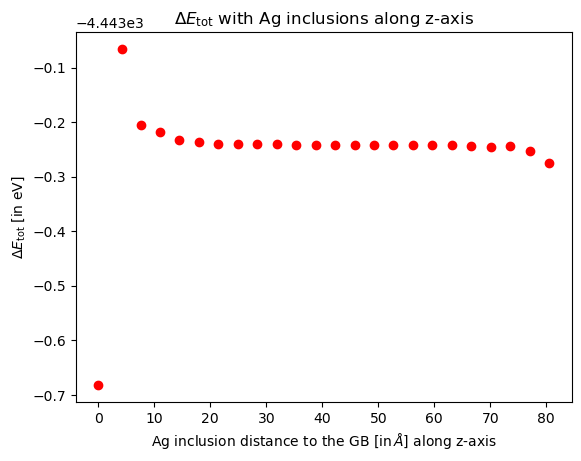

2025-05-15 17:16:48,720 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:16:48,721 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_Vac_deltas: [0.2541877197800204, 0.03690764124985435, 0.002809471900036442, -0.0013058351478321129, -0.0028115708410041407, -0.0010930379348792485, -0.0006928912407602184, -0.00031417083300766535, -0.00011937833642150508, -4.6130897317198105e-05, -1.3736765140492935e-05, 0.0, 7.13686222297838e-06, 1.206273736897856e-05, 1.970476660062559e-05, 2.957688229798805e-05, 2.8893192393297795e-05, 6.0816917539341375e-05, 0.00023369313657894963, 0.0007976656288519735, -0.00012669249099417357, 0.0034214484339827322, -0.031094036100512312, 0.3962382943909688]
sorted_Total_Energy_incl_deltas: [-0.44093676026295725, 0.17547902247224556, 0.0367864633735735, 0.02286616322453483, 0.007745501479803352, 0.004133714234740182, 0.0018234541066703969, 0.0009952653663276578, 0.0003885331889250665, 0.00016452902946184622, 4.034218454762595e-05, 0.0, -2.9217692826932762e-05, -4.252368216839386e-05, -5.769370091002202e-05, -0.00010368501534685493, -0.00019942407107009785, -0.00026172966227022

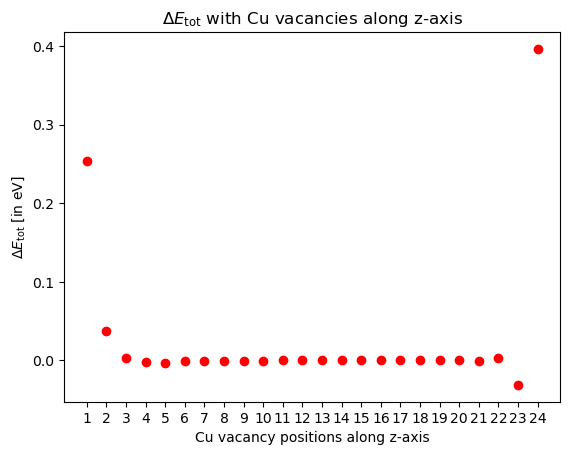

sorted_Total_Energy_Vac distance to GB plot:


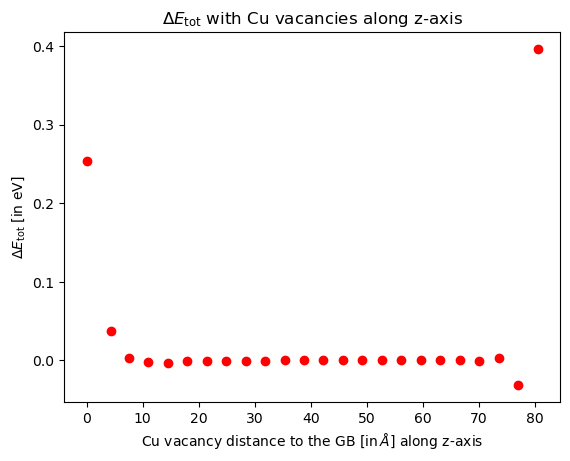

2025-05-15 17:16:48,913 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:16:48,914 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_Total_Energy_incl positions along z-axis plot:


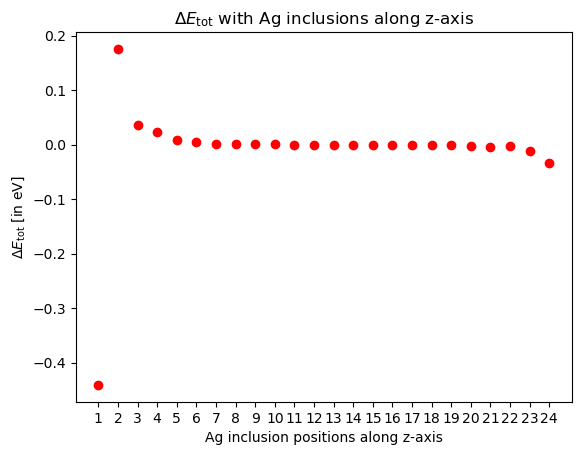

sorted_Total_Energy_incl distance to GB plot:


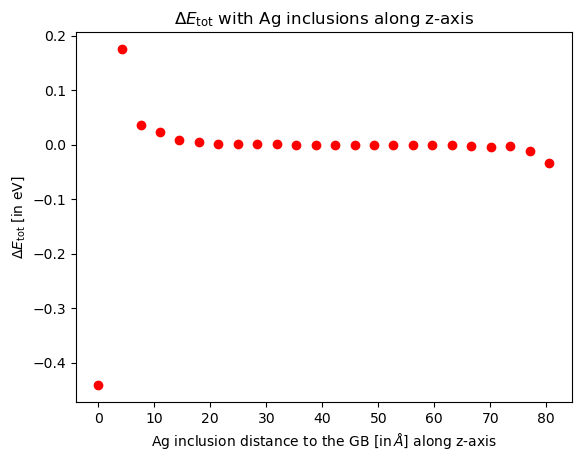


Timestamp:
15-05-2025 17:16


In [13]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
LAMMPS_index = '011'
#LAMMPS_index = input("Enter the LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        # Exact match with folder name
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error

            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value

#Quick plot:
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()



# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""
distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
print(f"distance_to_center_index_list = {distance_to_center_index_list}")

#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions}")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]

#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")


#Section 3 plot <-----------------------------------------------------------------OPEN


#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

#do both:



#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref = sorted_Total_Energy_Vac[11]
incl_ref = sorted_Total_Energy_incl[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas = [x - Vac_ref for x in sorted_Total_Energy_Vac]
sorted_Total_Energy_incl_deltas = [x - incl_ref for x in sorted_Total_Energy_incl]

print("sorted_Total_Energy_Vac_deltas:", sorted_Total_Energy_Vac_deltas)
print("sorted_Total_Energy_incl_deltas:", sorted_Total_Energy_incl_deltas)

#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
plt.show()

#do both:




# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format

2025-05-15 17:17:13,703 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:17:13,704 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


sorted_positions:['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'];
24 sorted_positions list entrys
sorted_Total_Energy_Vac:[-4440.3170272927755, -4440.534307371306, -4440.5684055406555, -4440.572520847703, -4440.5740265833965, -4440.57230805049, -4440.571907903796, -4440.5715291833885, -4440.571334390892, -4440.571261143453, -4440.571228749321, -4440.5712150125555, -4440.571207875693, -4440.571202949818, -4440.571195307789, -4440.571185435673, -4440.571186119363, -4440.571154195638, -4440.570981319419, -4440.570417346927, -4440.5713417050465, -4440.5677935641215, -4440.602309048656, -4440.1749767181645];
24 sorted_Total_Energy_Vac list entrys
sorted_Total_Energy_incl:[-4443.681879930195, -4443.065464147459, -4443.204156706558, -4443.218077006707, -4443.233197668452, -4443.236809455697, -4443.239119715825, -4443.239947904565, -4443.240554636743, -4443.240778640902, -4443.240902827747, -4443.2409431699

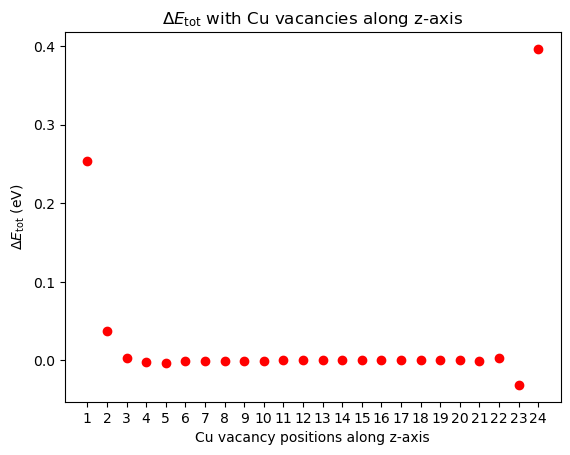

sorted_Total_Energy_Vac distance to GB plot:


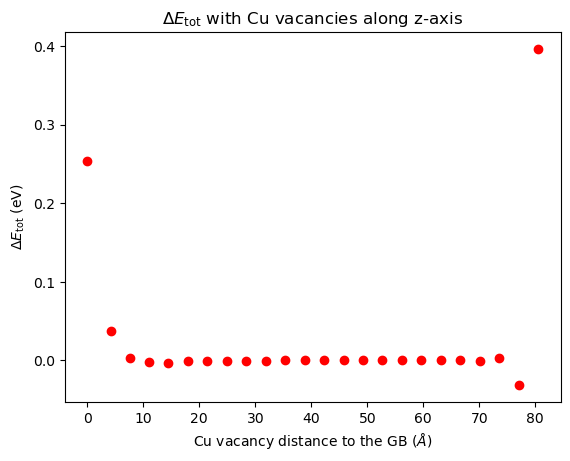

2025-05-15 17:17:13,907 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_incl positions along z-axis plot:


2025-05-15 17:17:13,907 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


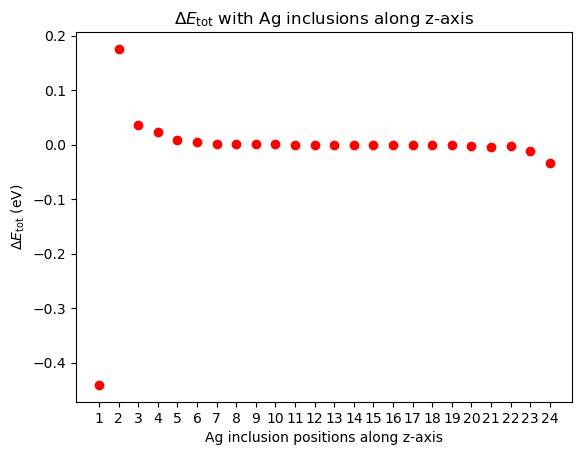

sorted_Total_Energy_incl distance to GB plot:


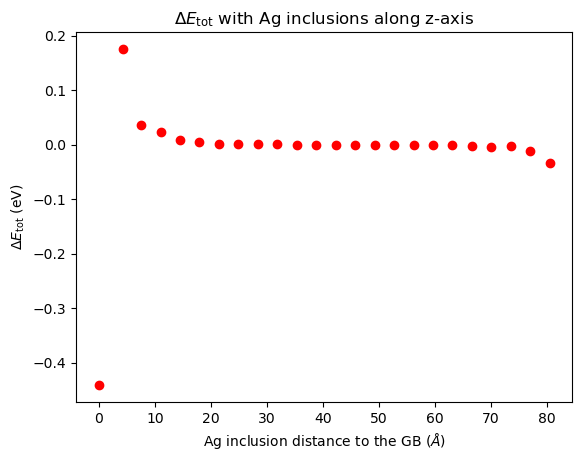

2025-05-15 17:17:14,114 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:17:14,115 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_incl positions along z-axis plot:


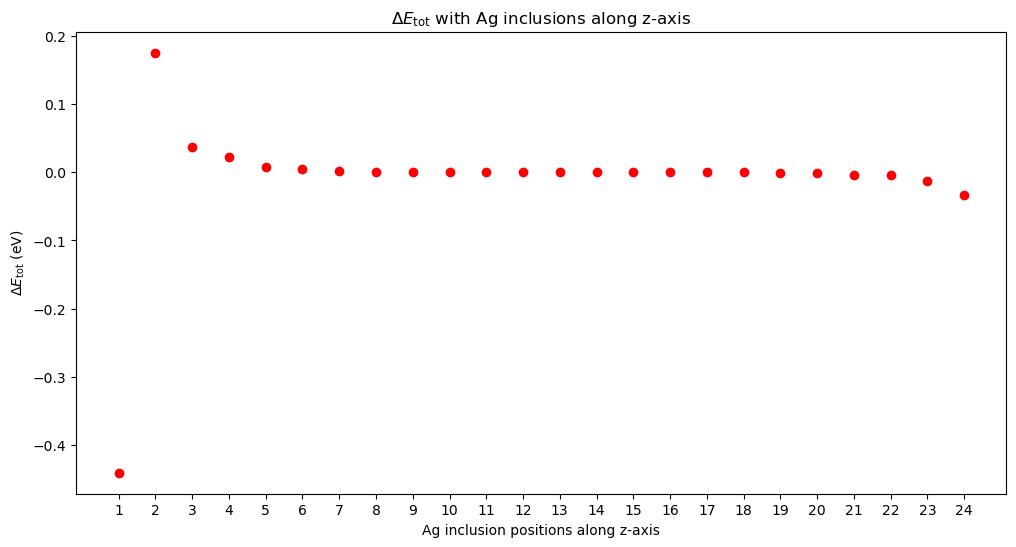

sorted_Total_Energy_incl distance to GB plot:


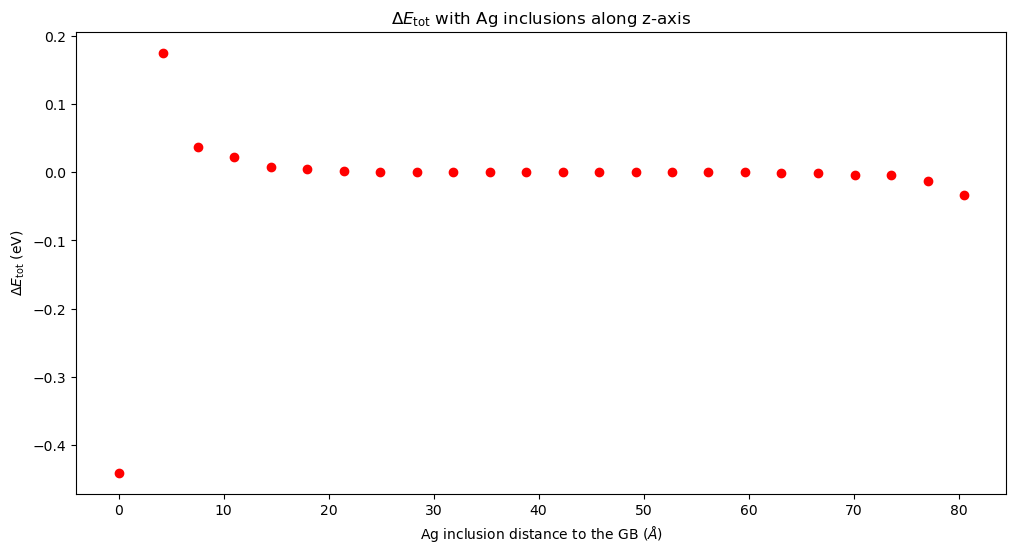

2025-05-15 17:17:14,418 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:17:14,419 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_incl positions along z-axis plot:


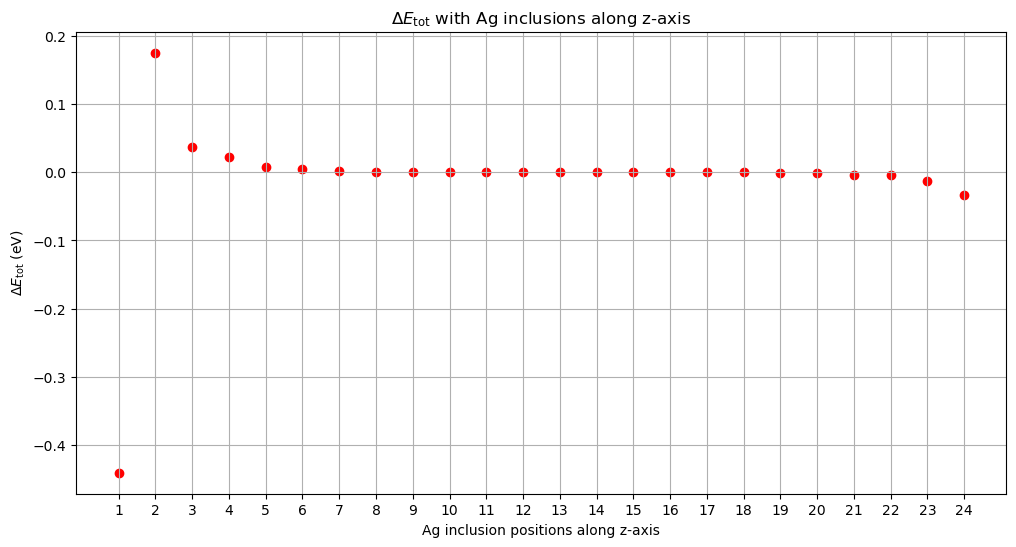

sorted_Total_Energy_incl distance to GB plot:


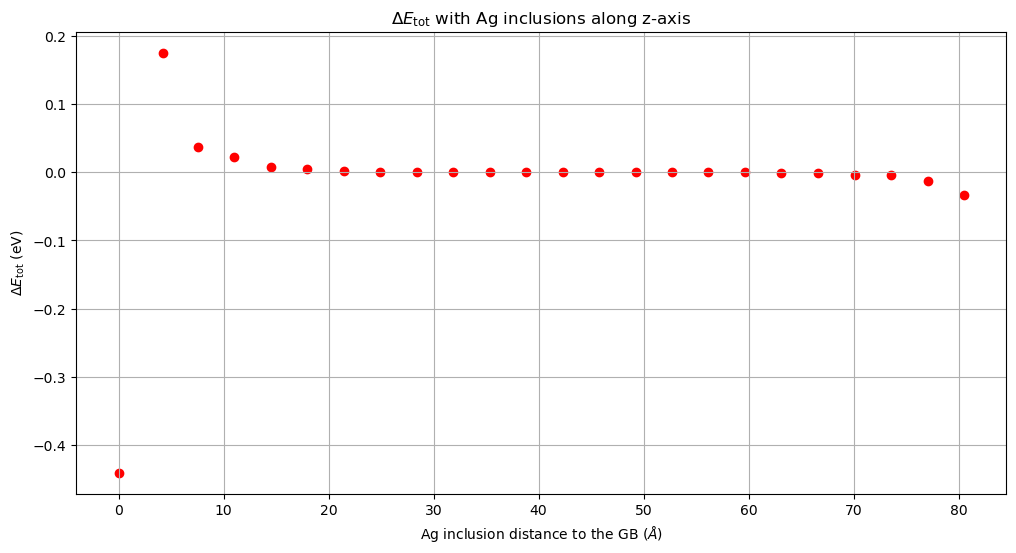

2025-05-15 17:17:14,648 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-15 17:17:14,649 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.




sorted_Total_Energy_Vac positions along z-axis plot:


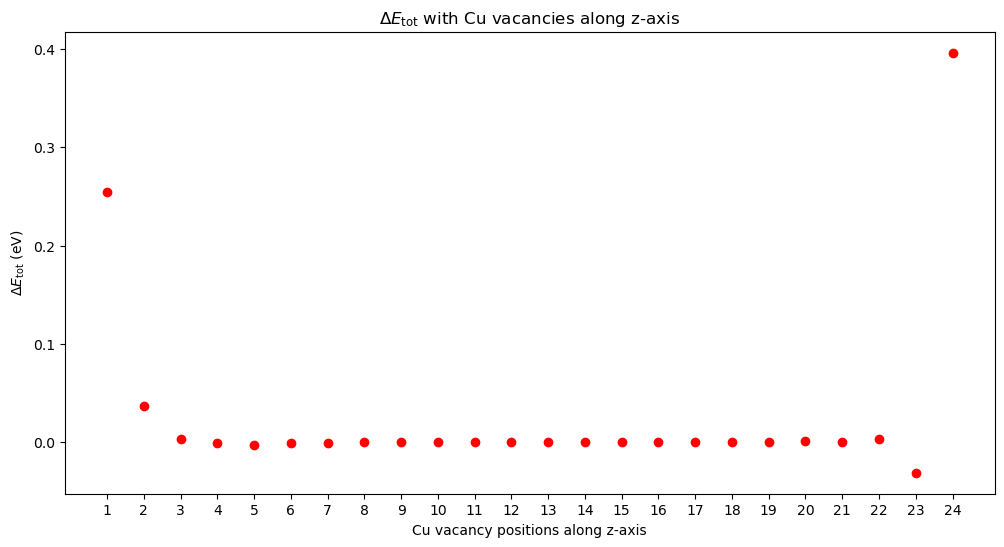

sorted_Total_Energy_Vac distance to GB plot:


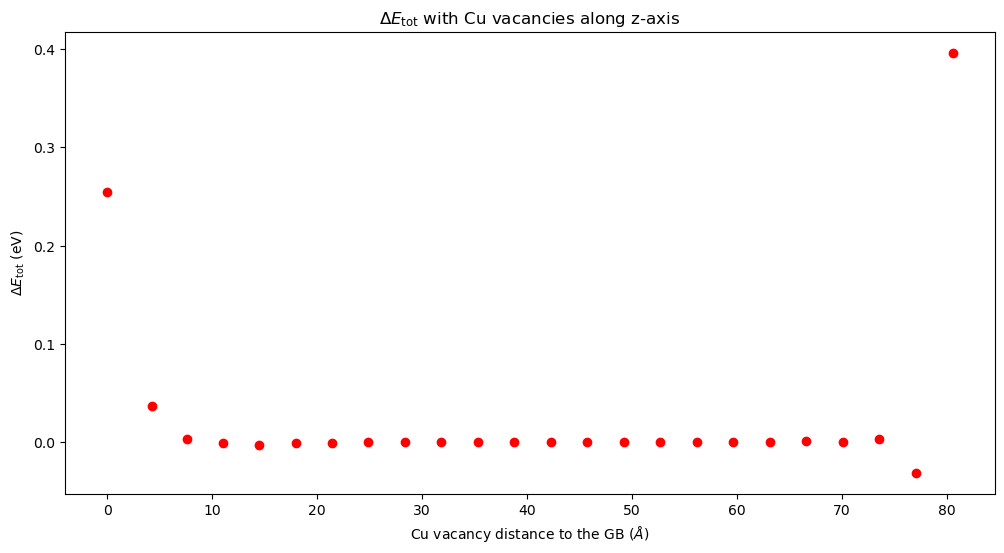

In [14]:
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")

print("sorted_Total_Energy_Vac_deltas:\n", sorted_Total_Energy_Vac_deltas)
print("sorted_Total_Energy_incl_deltas:\n", sorted_Total_Energy_incl_deltas)
print("\n")

#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()


print("\n")
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()


print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

#----------------------------------------------------------------------------------
print("\n")
# Wide plot for sorted_Total_Energy_incl positions along z-axis
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

# Wide plot for sorted_Total_Energy_incl distance to GB
print("sorted_Total_Energy_incl distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.grid(True)  # Optional: Add grid for better readability
plt.show()
#----------------------------------------------------------------------------------

print("\n")
#Quick plot:
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.figure(figsize=(12, 6))  # Adjust the width and height here
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB ($\AA$)')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ (eV)')
plt.show()

In [ ]:








#Comparision readout 017 up to 023









Enter the first LAMMPS index (e.g., 001, 002, ... etc.):  017
Enter the second LAMMPS index (e.g., 001, 002, ... etc.):  018


Folder name for 017 is: LAMMPS_Submision_017_20-05-2025_11-33-57
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos15-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data


/nfshome/okresa/anaconda3/envs/ASE_pyace_aimsgb/lib/python3.9/site-packages/ase/io/lammpsdata.py:49: FutureWarning: "style" is deprecated; please use "atom_style".
  warnings.warn(
/tmp/ipykernel_2198601/4020913409.py:184: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1481.9184556136129 eV
The Energy (per atom) is: -3.859162644827117 in eV per atom
Position: Pos15
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos15-Ag.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos2-Ag.mini.data
No Vac in folder name found
Confirm file: optimize1.data
Supercell potential Energy:
-1482.178128136951 eV
The Energy (per atom) is: -3.8598388753566435 in eV per atom
Position: Pos2
Ag DONE

/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z

/tmp/ipykernel_2198601/4020913409.py:131: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)


Supercell potential Energy:
-1479.1905090232458 eV
Undivided_Energy-1479.1905090232458
The Energy (per atom) is: -3.8621162115489445 in eV per atom
Position: Pos11
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos11-Vac.mini.data
No Ref in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Data/LAMMPS_Submision_017_20-05-2025_11-33-57/33_Submited_mini_data_folders/0_print_steps_CuGaSe2_GB_S9_12z-layers_Pos14-Vac.mini.data
Confirm file: optimize1.data
Supercell potential Energy:
-1479.189806626987 eV
Undivided_Energy-1479.189806626987
The Energy (per atom) is: -3.8621143776161544 in eV per atom
Position: Pos14
Vac DONE

No Ag in folder name found
/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model/data/LAMMPS_Dat

/tmp/ipykernel_2198601/4020913409.py:274: DeprecationWarning: Please use atoms.calc = calc
  atoms1.set_calculator(pot)
2025-05-26 16:01:22,721 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 16:01:22,724 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


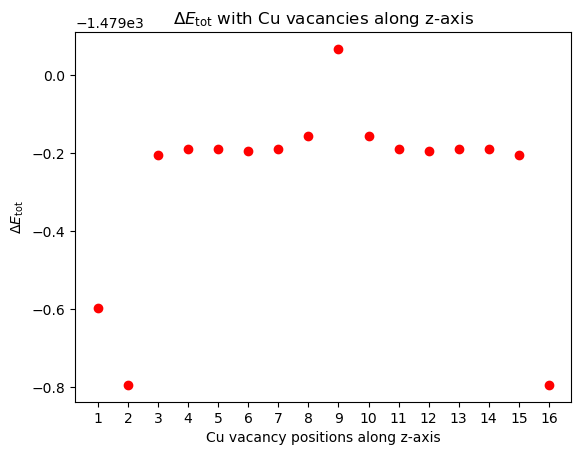

2025-05-26 16:01:23,323 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-05-26 16:01:23,325 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


first LAMMPS_index is:017
sorted_Total_Energy_incl plot:


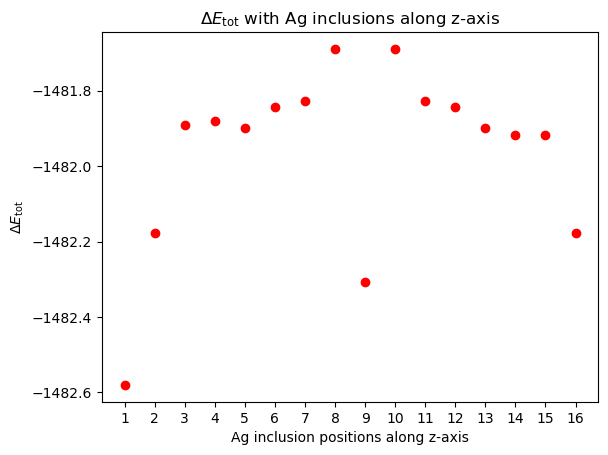

Energy_Delta_incl: [1.237557312746958, 0.9778847894087903, 1.4668853658304215, 1.3277829108963033, 1.2572724519259282, 1.2661274019476423, 0.5757051764810512, 1.4668853658304215, 1.3277829108981223, 1.3126044950456617, 1.2572724519261556, 1.2375023380643597, 0.977884789406744, 0.8481395449257434, 1.3126044950454343, 1.2768030568113318];
16 Energy_Delta_incl list entrys
Energy_Delta_Vac: [4.00004486492594, 3.9655039031140404, 3.966206299372743, 3.3618784716443315, 3.9520712021273994, 3.9520712021294457, 4.000044864925258, 4.222504146298434, 3.960006660190402, 3.5577343658280824, 3.960006660191766, 3.9659233548047723, 3.361878471645241, 3.966206299372061, 3.9659233548049997, 3.965503903115632];
16 Energy_Delta_Vac list entrys


Atoms(symbols='Cu96Ga96Se192', pbc=True, cell=[8.006053584728107, 19.623315244560512, 56.23681114532088], id=..., masses=..., momenta=..., type=...)
Center of the atoms: [ 4.00302679  9.80199987 27.5844096 ]
Closest Cu atom is at index 81 with coordinates: [ 5.442

NameError: name 'get_atoms_with_smaller_z' is not defined

In [10]:
#To do

from collections import defaultdict
import re


# Ask the user for the LAMMPS index
#LAMMPS_index = '011'
LAMMPS_index = input("Enter the first LAMMPS index (e.g., 001, 002, ... etc.): ")
LAMMPS_index_2 = input("Enter the second LAMMPS index (e.g., 001, 002, ... etc.): ")
#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX
#Section 1 read out energies from incl/Vac <----------------------------------------DONE NEEDS POLISH

incl = "Ag"

# Define the base directory
project_dir = "/nfshome/okresa/Bachelor_Thesis_Office/Project_Vacancy_Intersetiell_ASE_model"
base_dir = f"{project_dir}/data/LAMMPS_Data"

# Clear preexisting variables
layer = []
layers = []
e_pot_Vac = []
Total_Energy_Vac = []
Total_Energy_Vac_per_atom = []
e_pot_incl = []
Total_Energy_incl = []
Total_Energy_incl_per_atom = []
e_pot_ref = []
Total_Energy_ref = []
Total_Energy_ref_per_atom = []
n_reps = []

layer_2 = []
layers_2 = []
e_pot_Vac_2 = []
Total_Energy_Vac_2 = []
Total_Energy_Vac_per_atom_2 = []
e_pot_incl_2 = []
Total_Energy_incl_2 = []
Total_Energy_incl_per_atom_2 = []
e_pot_ref_2 = []
Total_Energy_ref_2 = []
Total_Energy_ref_per_atom_2 = []
n_reps_2 = []
"""
Formation_Energy = []

repeat = []
bulk_repeat = []
n_reps = []
rep = []
bulk_rep = []

Bulk_Energy = []
Bulk_Energy_per_atom = []
Total_Energy = []
Total_Energy_per_atom = []
e_pot = []
e_bulk = []
"""

# List all directories in the base directory
base_path = Path(base_dir)


# Initialize dictionaries to store energies for both Vac and incl
vac_energies_dict = defaultdict(list)
incl_energies_dict = defaultdict(list)

# Step 1: Find the folder name matching the pattern for LAMMPS_Submision:

folder_name = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index} is: {folder_name}")

if folder_name:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part = "_".join(folder_name.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission = f"LAMMPS_Submision_{LAMMPS_index}_{folder_part}"
    # Construct the full path
    submission_path = base_path / LAMMPS_Submission
else:
    print(f"No submission folder with index {LAMMPS_index} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 2:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder = f.parent
    grandparent_folder = parent_folder.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder))
        data_folder = grandparent_folder

        matchVac = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_Vac_str)
            position = matchVac.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_Vac_uncorrected = atoms1.get_potential_energy()
            e_pot_Vac = Corrected_Energy(e_pot_Vac_uncorrected, atoms1)
            # Add to the vac_energies dictionary
            vac_energies_dict[position].append(e_pot_Vac)
            print("Supercell potential Energy:")
            print(e_pot_Vac, "eV")
            Total_Energy_Vac.append(e_pot_Vac)
        
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_Vac
            print(f"Undivided_Energy{Undivided_Energy}")
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_Vac_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl:
            layers_incl_str = matchincl.group(1)  # Extract the z-layer value (e.g., 12)
            layers = int(layers_incl_str)
            position = matchincl.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1.set_calculator(pot)
            n_reps.append(len(atoms1))
            e_pot_incl_uncorrected = atoms1.get_potential_energy()
            e_pot_incl = Corrected_Energy(e_pot_incl_uncorrected, atoms1)
            # Add to the incl_energies dictionary
            incl_energies_dict[position].append(e_pot_incl)

            print("Supercell potential Energy:")
            print(e_pot_incl, "eV")
            Total_Energy_incl.append(e_pot_incl)
            
            #divide by atom count (needed?)
            Undivided_Energy = e_pot_incl
            Divided_Energy = Undivided_Energy/len(atoms1)
            Total_Energy_incl_per_atom.append(Divided_Energy)
            print(f"The Energy (per atom) is: {Divided_Energy} in eV per atom")
            print(f"Position: Pos{position}")
            if layer:
                print(f"{layer}layers_done\n")
                layers.append(layer)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder))
        data_folder = grandparent_folder
        # Replace with the actual path or folder object if needed
        data_folder_name = data_folder.name  # Assumes data_folder is a pathlib.Path or similar object

        
        # Exact match with folder name
        """
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
        #if data_folder_name == "0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error
                
        """

        '''
        # Match ONLY files like: 0_anything_CuGaSe2_..._z-layers_20A-VACUUMS.mini.data
        # and explicitly exclude ones that continue with "_pos" or other suffixes before .mini.data
        match_ref = re.match(r"0_.*CuGaSe2.*z-layers_20A-VACUUMS\.mini\.data$", data_folder_name)

        if match_ref:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Optional: fallback or warning
        '''
        
        # Match files that:
        # - start with 0_
        # - contain CuGaSe2
        # - end with .mini.data
        # - but do NOT contain "-Ag", "-Vac", or "Pos<digits>" anywhere
        is_reference_file = (
            data_folder_name.startswith("0_")
            and "CuGaSe2" in data_folder_name
            and data_folder_name.endswith(".mini.data")
            and not re.search(r"(Pos\d+|-Ag|-Vac)", data_folder_name)
        )
        
        if is_reference_file:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Or handle this more explicitly if needed
      
        
            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name}")

            
            GB = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms1 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms1.set_calculator(pot)

            n_reps.append(len(atoms1))

            e_pot_ref_uncorrected = atoms1.get_potential_energy()
            e_pot_ref = Corrected_Energy(e_pot_ref_uncorrected, atoms1)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy = e_pot_ref
            Divided_Energy = Undivided_Energy / len(atoms1)
            Total_Energy_ref_per_atom.append(Divided_Energy)
        
            print(f"The Energy (per atom) is: {Divided_Energy} eV per atom")

            if layers:
                print(f"{layers} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"first LAMMPS_index is:{LAMMPS_index}")
print(f"vac_energies_dict:\n{vac_energies_dict}\n") 
print(f"incl_energies_dict:\n{incl_energies_dict}\n") 

sorted_vac_energies_dict = sorted(vac_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict = sorted(incl_energies_dict.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions = []
sorted_Total_Energy_Vac = []
sorted_Total_Energy_incl = []

# Print out the sorted energies with their positions
print(f"first LAMMPS_index is:{LAMMPS_index}")
print("\nVacancy Energies (Sorted by Position):")
for pos, energies in sorted_vac_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_Vac.append(energies[0])  #Extract the energy float value
    sorted_positions.append(pos)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos, energies in sorted_incl_energies_dict:
    print(f"Pos: {pos}: {energies}")
    sorted_Total_Energy_incl.append(energies[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict:\n{sorted_vac_energies_dict}\n") 
print(f"sorted_incl_energies_dict:\n{sorted_incl_energies_dict}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac:{Total_Energy_Vac};\n{len(Total_Energy_Vac)} Total_Energy_Vac list entrys")
print(f"Total_Energy_incl:{Total_Energy_incl};\n{len(Total_Energy_incl)} Total_Energy_incl list entrys")


print("\n")
print(f"sorted_positions:{sorted_positions};\n{len(sorted_positions)} sorted_positions list entrys")
print(f"sorted_Total_Energy_Vac:{sorted_Total_Energy_Vac};\n{len(sorted_Total_Energy_Vac)} sorted_Total_Energy_Vac list entrys")
print(f"sorted_Total_Energy_incl:{sorted_Total_Energy_incl};\n{len(sorted_Total_Energy_incl)} sorted_Total_Energy_incl list entrys")
print(f"Total_Energy_ref:{Total_Energy_ref};\n{len(Total_Energy_ref)} Total_Energy_ref list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value


#Quick plot:
print(f"first LAMMPS_index is:{LAMMPS_index}")
print("sorted_Total_Energy_Vac plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print(f"first LAMMPS_index is:{LAMMPS_index}")
print("sorted_Total_Energy_incl plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy = Total_Energy_ref[0]

# Calculate delta lists
Energy_Delta_incl = [energy - ref_energy for energy in Total_Energy_incl]
Energy_Delta_Vac = [energy - ref_energy for energy in Total_Energy_Vac]

# Optional: print for confirmation
print(f"Energy_Delta_incl: {Energy_Delta_incl};\n{len(Energy_Delta_incl)} Energy_Delta_incl list entrys")
print(f"Energy_Delta_Vac: {Energy_Delta_Vac};\n{len(Energy_Delta_Vac)} Energy_Delta_Vac list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB)
#reminder no screen elemnts outside of the office possible
#GB.edit()


######################################################################################################################################
# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_revert = copy.deepcopy(GB)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_test1 = swap_atoms(GB, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""

#Step 1.4 create index list: distance_to_center_index_list 
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []

#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH

#def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
distance_to_center_index_list_1 = get_atoms_with_smaller_z(GB, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance= 0.7, x_tolerance = 3) 
distance_to_center_index_list_1.reverse()
print(f"distance_to_center_index_list_part1 = {distance_to_center_index_list_1}")

closest_atom_index_list = [closest_atom_index]
print(f"closest_atom_index_list (to center) = {closest_atom_index_list}")

distance_to_center_index_list_2 = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.7, x_tolerance = 3)    
print(f"distance_to_center_index_list_part2 = {distance_to_center_index_list_2}")

distance_to_center_index_list = distance_to_center_index_list_1 + closest_atom_index_list + distance_to_center_index_list_2
print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
#print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH




#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
ask_to_check_visuals = "skip"
#ask_to_check_visuals = "ask"
GB_test2 = swap_atoms(GB, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB = copy.deepcopy(GB_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

#print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")
print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions};\n{len(sorted_z_positions)} sorted_z_positions list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")



######################################################################################################################################

#WMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWMWM

# Step 3: Find the folder name matching the pattern for the second LAMMPS_Submision:

folder_name_2 = None
for folder in base_path.iterdir():
    if folder.is_dir() and folder.name.startswith(f"LAMMPS_Submision_{LAMMPS_index_2}_"):
        folder_name = folder.name
        break
print(f"Folder name for {LAMMPS_index_2} is: {folder_name_2}")

if folder_name_2:
    # Extract the relevant part of the folder name (after the index, including the date and time)
    folder_part_2 = "_".join(folder_name_2.split('_')[3:])
    # Construct the LAMMPS_Submission string
    LAMMPS_Submission_2 = f"LAMMPS_Submision_{LAMMPS_index_2}_{folder_part_2}"
    # Construct the full path
    submission_path_2 = base_path / LAMMPS_Submission_2
else:
    print(f"No submission folder with index {LAMMPS_index_2} found in /LAMMPS_Data")
    sys.exit(1) #exits the script in case of an error

"""
# Extra step: Create folder for graphs:

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_formation_energies_graphs_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)
"""

# Step 4:  Loop through the files and calculate the energies based on Bulk and GB versions:

for f in submission_path_2.glob("*_Submited_mini_data_folders/*.data/T_*/optimize1.data"):
    # Get the parent directory of the file
    parent_folder_2 = f.parent
    grandparent_folder_2 = parent_folder_2.parent
        # Check if "BULK" is in the parent folder's name
    if "BULK" in grandparent_folder_2.name:
        continue # Skip BULK files
    else:
        #TO DO split this one into 3 parts

        #Read out Vacancy versions:
        
        # If the folder does not contain "BULK", process the file
        print(Path(grandparent_folder_2))
        data_folder_2 = grandparent_folder_2

        matchVac_2 = re.search(r'(\d+)z-layers.*?Pos(\d+)-Vac\.mini\.data$', data_folder.name)
        
        if matchVac_2:
            #old:
            #layers_Vac_str = matchVac.group(1)  # Extract the z-layer value (e.g., 12)
            layers_Vac_str_2 = matchVac_2.group(1)  # Extract the z-layer value (e.g., 12)
            layers_2 = int(layers_Vac_str_2)
            position_2 = matchVac_2.group(2)  # Extract the position (e.g., Pos14)

            print(f"Confirm file: {f.name}")

            # Read the atoms data
            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms2.set_calculator(pot)
            n_reps.append(len(atoms2))
            e_pot_Vac_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_Vac_2 = Corrected_Energy(e_pot_Vac_uncorrected_2, atoms2)
            # Add to the vac_energies dictionary
            vac_energies_dict_2[position].append(e_pot_Vac_2)
            print("Supercell potential Energy:")
            print(e_pot_Vac_2, "eV")
            Total_Energy_Vac_2.append(e_pot_Vac_2)
        
            #divide by atom count (needed?)
            Undivided_Energy_2 = e_pot_Vac_2
            print(f"Undivided_Energy{Undivided_Energy_2}")
            Divided_Energy_2 = Undivided_Energy_2/len(atoms2)
            Total_Energy_Vac_per_atom_2.append(Divided_Energy_2)
            print(f"The Energy (per atom) is: {Divided_Energy_2} in eV per atom")
            print(f"Position: Pos{position_2}")
            if layer_2:
                print(f"{layer_2}layers_done\n")
                layers_2.append(layer_2)
            print("Vac DONE\n")
            
        else:
            print(f"No Vac in folder name found")
            #continue  # Skip if no layer count is found
        
        #-----------------------------------------------------------------------------------------

        #old
        #matchincl = re.search(r'(\d+)z-layers.*?Pos\d+-Ag\.mini\.data$', data_folder.name)
        matchincl_2 = re.search(r'(\d+)z-layers.*?Pos(\d+)-Ag\.mini\.data$', data_folder.name)

        #Read out incl versions:
        
        #replace Ag with incl  
        #new approach: # <------------------------------------------------------------------------------- OPEN
        #pattern = re.compile(r'(\d+)z-layers.*?Pos\d+-' + re.escape(incl) + r'\.mini\.data$')

        # Test filenames
        #filename1 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Ag.mini.data"
        #filename2 = "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS_Pos14-Vac.mini.data"

        #print(bool(pattern.search(filename1)))  # ✅ True if incl = "Ag"
        #print(bool(pattern.search(filename2)))  # ❌ False if incl = "Ag"
        
        if matchincl_2:
            layers_incl_str_2 = matchincl_2.group(1)  # Extract the z-layer value (e.g., 12)
            layers_2 = int(layers_incl_str_2)
            position_2 = matchincl_2.group(2)  # Extract the position (e.g., Pos14)
            
            print(f"Confirm file: {f.name}")

            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms2.set_calculator(pot)
            n_reps.append(len(atoms2))
            e_pot_incl_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_incl_2 = Corrected_Energy(e_pot_incl_uncorrected_2, atoms2)
            # Add to the incl_energies dictionary
            incl_energies_dict_2[position].append(e_pot_incl_2)

            print("Supercell potential Energy:")
            print(e_pot_incl_2, "eV")
            Total_Energy_incl_2.append(e_pot_incl_2)
            
            #divide by atom count (needed?)
            Undivided_Energy_2 = e_pot_incl_2
            Divided_Energy_2 = Undivided_Energy_2/len(atoms2)
            Total_Energy_incl_per_atom_2.append(Divided_Energy_2)
            print(f"The Energy (per atom) is: {Divided_Energy_2} in eV per atom")
            print(f"Position: Pos{position_2}")
            if layer_2:
                print(f"{layer_2}layers_done\n")
                layers_2.append(layer_2)
            print(f"{incl} DONE\n")
            
        else:
            print(f"No {incl} in folder name found")
            #continue  # Skip if no layer count is found

        #---------------------------------------------------------------------------------------

        #OPEN read in reference Energy OPEN <-------------------------------------

        #look into If the folder does not contain "BULK" bzw "incl" or Vac, process the file
        # Use regular expression to extract repetition value (e.g., 2 from 2rep*.data)
        print(Path(grandparent_folder_2))
        data_folder_2 = grandparent_folder_2
        # Replace with the actual path or folder object if needed
        data_folder_name_2 = data_folder_2.name  # Assumes data_folder is a pathlib.Path or similar object

        
        # Exact match with folder name
        """
        if data_folder_name == "0_basic_CuGaSe2_GB_S9_36z-layers_20A-VACUUMS.mini.data":
        #if data_folder_name == "0_print_steps_CuGaSe2_GB_S9_12z-layers.mini.data":
            # Optional: extract the '36z' value if needed (not currently used)
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # or handle the error
                
        """

        '''
        # Match ONLY files like: 0_anything_CuGaSe2_..._z-layers_20A-VACUUMS.mini.data
        # and explicitly exclude ones that continue with "_pos" or other suffixes before .mini.data
        match_ref = re.match(r"0_.*CuGaSe2.*z-layers_20A-VACUUMS\.mini\.data$", data_folder_name)

        if match_ref:
            match_layers = re.search(r'(\d+)z-layers', data_folder_name)
            if match_layers:
                layers = int(match_layers.group(1))
            else:
                layers = None  # Optional: fallback or warning
        '''
        
        # Match files that:
        # - start with 0_
        # - contain CuGaSe2
        # - end with .mini.data
        # - but do NOT contain "-Ag", "-Vac", or "Pos<digits>" anywhere
        is_reference_file_2 = (
            data_folder_name_2.startswith("0_")
            and "CuGaSe2" in data_folder_name_2
            and data_folder_name_2.endswith(".mini.data")
            and not re.search(r"(Pos\d+|-Ag|-Vac)", data_folder_name_2)
        )
        
        if is_reference_file_2:
            match_layers_2 = re.search(r'(\d+)z-layers', data_folder_name_2)
            if match_layers_2:
                layers_2 = int(match_layers_2.group(1))
            else:
                layers_2 = None  # Or handle this more explicitly if needed
      
        
            print(f"\n##############################################################################################################################")
            print(f"Confirm folder: {data_folder_name_2}")

            
            GB_2 = read(f, format='lammps-data', style='atomic', Z_of_type={1:31, 2:29, 3:47, 4:34})
            atoms2 = read(f, format='lammps-data', style='atomic', Z_of_type={1: 31, 2: 29, 3: 47, 4: 34})
            atoms2.set_calculator(pot)

            n_reps.append(len(atoms2))

            e_pot_ref_uncorrected_2 = atoms2.get_potential_energy()
            e_pot_ref_2 = Corrected_Energy(e_pot_ref_uncorrected_2, atoms2)

            print("Supercell potential Energy:")
            print(e_pot_ref, "eV")
            Total_Energy_ref.append(e_pot_ref)

            Undivided_Energy_2 = e_pot_ref_2
            Divided_Energy_2 = Undivided_Energy_2 / len(atoms2)
            Total_Energy_ref_per_atom_2.append(Divided_Energy_2)
        
            print(f"The Energy (per atom) is: {Divided_Energy_2} eV per atom")

            if layers_2:
                print(f"{layers_2} layers done\n")

            print("ref DONE")
            print(f"##############################################################################################################################\n")
        else:
            print("No Ref in folder name found")
        

        #-----------------------------------------------------------------------------------------
        #create dict (pos|energy)


        #-----------------------------------------------------------------------------------------


print("\n")
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print(f"vac_energies_dict_2:\n{vac_energies_dict_2}\n") 
print(f"incl_energies_dict_2:\n{incl_energies_dict_2}\n") 

sorted_vac_energies_dict_2 = sorted(vac_energies_dict_2.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"
sorted_incl_energies_dict_2 = sorted(incl_energies_dict_2.items(), key=lambda x: int(x[0])) # Extract number from "PosXX"

sorted_positions_2 = []
sorted_Total_Energy_Vac_2 = []
sorted_Total_Energy_incl_2 = []

# Print out the sorted energies with their positions
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("\nVacancy Energies (Sorted by Position):")
for pos_2, energies_2 in sorted_vac_energies_dict_2:
    print(f"Pos: {pos_2}: {energies_2}")
    sorted_Total_Energy_Vac_2.append(energies_2[0])  #Extract the energy float value
    sorted_positions_2.append(pos_2)  #Extract the position int value

print("\nInclination Energies (Sorted by Position):")
for pos_2, energies_2 in sorted_incl_energies_dict_2:
    print(f"Pos: {pos_2}: {energies_2}")
    sorted_Total_Energy_incl_2.append(energies_2[0]) #Extract the float value

print(f"\nsorted_vac_energies_dict_2:\n{sorted_vac_energies_dict_2}\n") 
print(f"sorted_incl_energies_dict_2:\n{sorted_incl_energies_dict_2}\n") 

print("\n")
print("For comparison: old unsorted:")
print(f"Total_Energy_Vac_2:{Total_Energy_Vac_2};\n{len(Total_Energy_Vac_2)} Total_Energy_Vac_2 list entrys")
print(f"Total_Energy_incl_2:{Total_Energy_incl_2};\n{len(Total_Energy_incl_2)} Total_Energy_incl_2 list entrys")


print("\n")
print(f"sorted_positions_2:{sorted_positions_2};\n{len(sorted_positions_2)} sorted_positions_2 list entrys")
print(f"sorted_Total_Energy_Vac_2:{sorted_Total_Energy_Vac_2};\n{len(sorted_Total_Energy_Vac_2)} sorted_Total_Energy_Vac_2 list entrys")
print(f"sorted_Total_Energy_incl_2:{sorted_Total_Energy_incl_2};\n{len(sorted_Total_Energy_incl_2)} sorted_Total_Energy_incl_2 list entrys")
print(f"Total_Energy_ref_2:{Total_Energy_ref_2};\n{len(Total_Energy_ref_2)} Total_Energy_ref_2 list entrys")
print("\n")


#read out Total Energy for all 24 pos Vac | DONE
#24 values

#read out Total Energy for all 24 pos Ag/Cu? | DONE
#24 values

#read out Total Energy for reference | DONE
#1 value


#Quick plot:
print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("sorted_Total_Energy_Vac_2 plot:")
plt.scatter(sorted_positions_2, sorted_Total_Energy_Vac_2, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()

print(f"second LAMMPS_index is:{LAMMPS_index_2}")
print("sorted_Total_Energy_incl_2 plot:")
plt.scatter(sorted_positions_2, sorted_Total_Energy_incl_2, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$')
plt.show()


# Step 3:  Calculate Enegy Delta:

# Assuming Total_Energy_ref has only one value
ref_energy_2 = Total_Energy_ref_2[0]

# Calculate delta lists
Energy_Delta_incl_2 = [energy_2 - ref_energy_2 for energy_2 in Total_Energy_incl_2]
Energy_Delta_Vac_2 = [energy_2 - ref_energy_2 for energy_2 in Total_Energy_Vac_2]

# Optional: print for confirmation
print(f"Energy_Delta_incl_2: {Energy_Delta_incl_2};\n{len(Energy_Delta_incl_2)} Energy_Delta_incl_2 list entrys")
print(f"Energy_Delta_Vac_2: {Energy_Delta_Vac_2};\n{len(Energy_Delta_Vac_2)} Energy_Delta_Vac_2 list entrys")
print("\n")

#XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX

#Section 2 get distance of position <---------------------------------------------DONE


#find Ag pre for all 24 pos
#read files:
#create list:
incl_pos_pre = []

#find Vac pre from Ag pre (should be the same)
#read files:
#create list:
vac_pos_pre = []

#find Ag post for all 24 pos
#read files:
#create list:
incl_pos_post = []

#find Vac post for all 24 pos (is it the same?)
#read files:
#create list:
vac_pos_post = []


#Step 1: Find positions:

# Step 8.0 index Cu center to border:
#print("edit 1")
print(GB_2)
#reminder no screen elemnts outside of the office possible
#GB.edit()


######################################################################################################################################
# Problem: Shallow Copy: GB_revert = GB creates a shallow copy of GB. 
# This means both GB_revert and GB reference the same object (atoms list).
# Solution:
# Create a deep copy of GB
GB_2_revert = copy.deepcopy(GB_2)  # Make sure GB_revert is an independent copy
"""
print(GB_revert)
GB.edit()
"""

# Step 8.1 find center
center = find_center_of_atoms(GB_2)

# Step 8.2 find Cu pos closest to center
closest_atom_index, closest_atom_position = find_closest_atom_to_center(GB_2, center, "Cu")
#print(f"TEST: Closest Cu atom is at index {closest_atom_index} with coordinates: {closest_atom_position}")

# Step 8.2.1 confirm Cu (replace with Bi)
ask_to_check_visuals = "skip"

GB_2_test1 = swap_atoms(GB_2, closest_atom_index, "Bi")
print(f"ask_user_for_visuals for Step: 8.2.1 confirm Cu (replace with Bi)")
ask_user_for_visuals(GB_2_test1, ask_to_check_visuals)

# Reset the symbols to the original (using the deep copy)
GB_2 = copy.deepcopy(GB_2_revert)  # Revert back to the original state

print(f"index center atom: {closest_atom_index}")

"""
print("edit 2")
print(GB_revert)
print(GB)
GB.edit()

print("\n\nExecution is being cancelled 1. Breaking the script.")
sys.exit()  # Exit the script immediately
"""


#Step 8.3 find Cu pos > center (in x or y tolerance room? 1 [x] strict \ \ \ \ pattern should not matter --> periodicity)
#and create index list: distance_to_center_index_list 
"""
#distance_to_center_index_list = [closest_atom_index]
#distance_to_center_index_list.append(next_atom_index)
#distance_to_center_index_list = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
"""

#Step 1.4 create index list: distance_to_center_index_list 
distance_to_center_index_list = []
distance_to_center_index_list_1 = []
distance_to_center_index_list_2 = []

#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH

#def get_atoms_with_smaller_z(atoms, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance=0.1):
distance_to_center_index_list_1 = get_atoms_with_smaller_z(GB, closest_atom_position, closest_atom_index, bulk_base="Cu", y_tolerance= 0.7, x_tolerance = 3) 
distance_to_center_index_list_1.reverse()
print(f"distance_to_center_index_list_part1 = {distance_to_center_index_list_1}")

closest_atom_index_list = [closest_atom_index]
print(f"closest_atom_index_list (to center) = {closest_atom_index_list}")

distance_to_center_index_list_2 = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.7, x_tolerance = 3)    
print(f"distance_to_center_index_list_part2 = {distance_to_center_index_list_2}")

distance_to_center_index_list = distance_to_center_index_list_1 + closest_atom_index_list + distance_to_center_index_list_2
print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#distance_to_center_index_list = get_atoms_with_larger_z(GB, closest_atom_position, closest_atom_index, bulk_base = "Cu", y_tolerance = 0.5)    
#print(f"distance_to_center_index_list = {distance_to_center_index_list}")


#XHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXHXH




#Step 8.4 test version --> untill surface is hit (save atoms object as GB_incl_long)
ask_to_check_visuals = "skip"
#ask_to_check_visuals = "ask"
GB_2_test2 = swap_atoms(GB_2, distance_to_center_index_list, "Bi")
#view(GB_test2)
print(f"ask_user_for_visuals for Step: 8.4 test version --> untill surface is hit")
ask_user_for_visuals(GB_2_test2, ask_to_check_visuals)
# Reset the symbols to the original (using the deep copy)
GB_2 = copy.deepcopy(GB_2_revert)  # Revert back to the original state
#print("edit 3")
#GB.edit()

#print(f"index list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")
print(f"\nindex list: {distance_to_center_index_list};\n{len(distance_to_center_index_list)} distance_to_center_index_list list entrys")

# Extract z-positions of atoms at the given indices
z_positions = [GB[i].position[2] for i in distance_to_center_index_list]

# Sort the z-positions from small to large
sorted_z_positions = sorted(z_positions)

# Print the sorted z-positions
print(f"sorted_z_positions:\n {sorted_z_positions};\n{len(sorted_z_positions)} sorted_z_positions list entrys")
print(f"Closest Cu atom to center is at index {closest_atom_index} with coordinates: {closest_atom_position}")
print(f"center_z_position is {closest_atom_position[2]}")
#Closest Cu atom is at index 271 with coordinates: [  5.44242076  10.91675073 103.01715074]


#Step 2: get positon Delta (rel to center):
#calculate delta: [Pos pre]-[Pos post]??? (nessecary?) --> NO! Distance to Center Atom!!! (get center from function in ASE)!
#_pre or _post static relaxation pos? ==> select and print result Pre relax /post static / post MD

# Subtract the center z position from each sorted z position to get the delta (difference)
delta_z_positions = [z - closest_atom_position[2] for z in sorted_z_positions]
print(f"\ndelta_z_positions:\n {delta_z_positions};\n{len(delta_z_positions)} delta_z_positions list entrys")



######################################################################################################################################


#Section 5 plot

# Extra step: Create folder for graphs:
print("\n\nPlot collection:")
print(f"first LAMMPS_index is:{LAMMPS_index}")
print(f"second LAMMPS_index is:{LAMMPS_index_2}")

print(f"LAMMPS_Submission:\n{submission_path}\n")
submission_graph_path = submission_path / f"zz_segregation_energies_for_{LAMMPS_index}"
# Create the folder if it doesn't exist
os.makedirs(submission_graph_path, exist_ok=True)

print(f"sorted_Total_Energy_Vac:\n{sorted_Total_Energy_Vac}")
print(f"sorted_Total_Energy_incl:\n{sorted_Total_Energy_incl}")
print(f"delta_z_positions:\n{delta_z_positions}")
print(f"sorted_positions:\n{sorted_positions}")


#Expressed as a DELTA to the energy value in the middle:
# Identifying the middle element (12th entry, index 11 in 0-based indexing)
Vac_ref = sorted_Total_Energy_Vac[11]
incl_ref = sorted_Total_Energy_incl[11]

# Computing the deltas for both lists relative to their respective references
sorted_Total_Energy_Vac_deltas = [x - Vac_ref for x in sorted_Total_Energy_Vac]
sorted_Total_Energy_incl_deltas = [x - incl_ref for x in sorted_Total_Energy_incl]


#print("sorted_Total_Energy_Vac_deltas:", sorted_Total_Energy_Vac_deltas)
#print("sorted_Total_Energy_incl_deltas:", sorted_Total_Energy_incl_deltas)
print(f"sorted_Total_Energy_Vac_deltas:\n {sorted_Total_Energy_Vac_deltas};\n{len(sorted_Total_Energy_Vac_deltas)} sorted_Total_Energy_Vac_deltas list entrys")
print(f"sorted_Total_Energy_incl_deltas:\n {sorted_Total_Energy_incl_deltas};\n{len(sorted_Total_Energy_incl_deltas)} sorted_Total_Energy_incl_deltas list entrys")


#Quick plot:
#Vacancies
print("sorted_Total_Energy_Vac positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_Vac distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_Vac_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Cu vacancies along z-axis')
plt.xlabel('Cu vacancy distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Vac_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()


#Inclusions (silver solvents)
print("sorted_Total_Energy_incl positions along z-axis plot:")
plt.scatter(sorted_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion positions along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_pos.png", bbox_inches='tight') 
plt.show()

print("sorted_Total_Energy_incl distance to GB plot:")
plt.scatter(delta_z_positions, sorted_Total_Energy_incl_deltas, color='red')
plt.title(r'$\Delta E_{\mathrm{tot}}$ with Ag inclusions along z-axis')
plt.xlabel('Ag inclusion distance to the GB [in$\,\AA$] along z-axis')
plt.ylabel(r'$\Delta E_{\mathrm{tot}}$ [in eV]')
#plt.show()
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}_Ag_Segregation_Energy_deltas_distance.png", bbox_inches='tight') 
plt.show()

#do both:

"""
# Show the plot
plt.savefig(f"{submission_graph_path}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.savefig(f"{common_graph_folder}/{LAMMPS_index}Segregation_Energies.png", bbox_inches='tight') 
plt.show()
"""

print(f"{LAMMPS_index}_part1_DONE")

# Get the current date and time
import datetime # Import the 'datetime' module to work with date and time
now = datetime.datetime.now()# Create a datetime object representing the current date and time
print("\nTimestamp:")# Display a message indicating what is being printed
print(now.strftime("%d-%m-%Y %H:%M"))# Print the current date and time in a specific format "%Y-%m-%d %H:%M:%S"
# Use the 'strftime' method to format the datetime object as a string with the desired format